In [1]:
import pandas as pd
import numpy as np
import os
import time
import glob

from scipy.io import wavfile, savemat
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.fft import fftshift
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

import librosa
import mne
import pymatreader
import yasa
import seaborn as sns
import pyxdf

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

/home/shivam/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# CNN packages
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD,RMSprop,Adam
from keras.utils import np_utils
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

2023-06-06 20:15:22.185103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 20:15:22.304398: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-06 20:15:22.839513: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/shivam/anaconda3/lib/:/home/shivam/anaconda3/lib/
2023-06-06 20:15:22.839603: W 

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Looking for common good channels

In [4]:
dataset = pd.read_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/CleanSep/cleaned_data_asr.csv")
dataset

0          1          2          3          4          5  \
0       -4.671667  -4.451136  -4.263363  -4.122293  -4.039534  -4.023682   
1        6.391617   6.335880   6.244392   6.109434   5.925195   5.688357   
2        0.160325   0.081283  -0.010762  -0.123249  -0.262893  -0.435155   
3       -1.336037  -1.659968  -1.983633  -2.302723  -2.612850  -2.909530   
4       12.797042  12.577418  12.352886  12.123366  11.889187  11.651197   
...           ...        ...        ...        ...        ...        ...   
384955  -1.525676  -1.255532  -0.849529  -0.324107   0.302524   1.010990   
384956   0.430836   1.836212   3.301004   4.780484   6.231448   7.613512   
384957   2.463603   3.943370   5.494955   7.070804   8.621435  10.097134   
384958  -4.482436  -4.953345  -5.120734  -4.995581  -4.599613  -3.963956   
384959  -9.999717 -10.403556 -10.467914 -10.211440  -9.665377  -8.871596   

                6          7          8          9  ...       1096       1097  \
0       -4.079801  -4.209121  -4.408905  -4.672575  ...  -8.788404  -8.901701   
1        5.398465   5.058200   4.673382   4.252845  ... -20.972265 -20.743320   
2       -0.643720  -0.890082  -1.173304  -1.489870  ...   7.087850   7.448699   
3       -3.188195  -3.444230  -3.673032  -3.870121  ...  10.234831  10.642152   
4       11.410817  11.170057  10.931464  10.698002  ...   4.104468   3.970622   
...           ...        ...        ...        ...  ...        ...        ...   
384955   1.781305   2.593337   3.427199   4.263574  ...  -9.633747 -10.102177   
384956   8.890228  10.029982  11.006654  11.800056  ... -18.231979 -18.785727   
384957  11.449710  12.634233  13.610693  14.345462  ...  -9.042601  -8.470536   
384958  -3.127460  -2.134715  -1.033886   0.125495  ...  -4.829801  -5.120802   
384959  -7.880202  -6.746828  -5.529747  -4.286967  ...  -3.625640  -4.091861   

             1098       1099   handPos   Hand  Action  Subject  Channel  Trial  
0       -8.911717  -8.817698  palmDown  Right    Open      P01        1      1  
1      -20.478785 -20.176245  palmDown  Right    Open      P01        2      1  
2        7.722362   7.906469  palmDown  Right    Open      P01        3      1  
3       11.007372  11.328000  palmDown  Right    Open      P01        4      1  
4        3.816026   3.642702  palmDown  Right    Open      P01        5      1  
...           ...        ...       ...    ...     ...      ...      ...    ...  
384955 -10.289121 -10.183593    palmUp  Right   Close     FP12       58    480  
384956 -18.982012 -18.810005    palmUp  Right   Close     FP12       59    480  
384957  -7.647579  -6.599504    palmUp  Right   Close     FP12       60    480  
384958  -5.356338  -5.527806    palmUp  Right   Close     FP12       61    480  
384959  -4.593482  -5.115079    palmUp  Right   Close     FP12       62    480  

[384960 rows x 1106 columns]

In [5]:
chans, chan_count = np.unique(dataset["Channel"], return_counts=True)
chans, chan_count

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 array([5760, 6240, 6240, 6240, 6240, 6240, 5760, 6240, 6240, 5760, 6240,
        6240, 6240, 6240, 6240, 6240, 6240, 6240, 6240, 5760, 5760, 6240,
        6240, 5760, 6240, 6240, 6240, 6240, 6240, 6240, 6240, 6240, 6240,
        6240, 4800, 6240, 5280, 6240, 4800, 6240, 5280, 6240, 6240, 6240,
        6240, 6240, 6240, 6240, 5760, 6240, 5760, 5280, 6240, 6240, 6240,
        6240, 6240, 6240, 6240, 6240, 6240, 4320, 3840, 5760]))

In [6]:
# Find list of channels available for every participant
good_chans = [i+1 for i in range(len(chan_count)) if chan_count[i] == 6240]
print(len(good_chans))
print(good_chans)

48
[2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 40, 42, 43, 44, 45, 46, 47, 48, 50, 53, 54, 55, 56, 57, 58, 59, 60, 61]


In [7]:
# Subject-wise channel availability
sub_good_chans = {}
for sub in np.unique(dataset["Subject"]):
    sub_good_chans[sub] = np.unique(dataset[dataset["Subject"] == sub]["Channel"]) 
sub_good_chans

{'FP02': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 'FP03': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 'FP05': array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
 'FP06': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 22, 23, 24, 25, 26

# Spectopo Based Classification 

# Take spectopo of common channels!!!

In [8]:
os.chdir("/DATAHDD/shivam/Thesis/Data/Preprocessed/ASR/Spectopo ASR/")
processed = glob.glob("*.mat")
len(processed), processed

(6240,
 ['FP06-palmIn-Right-Close-35_spec.mat',
  'FP07-palmUp-Left-Close-319_spec.mat',
  'FP08-palmIn-Left-Close-408_spec.mat',
  'FP08-palmDown-Right-Open-193_spec.mat',
  'FP02-palmUp-Right-Close-16_spec.mat',
  'FP06-palmUp-Left-Open-413_spec.mat',
  'P01-palmIn-Right-Close-195_spec.mat',
  'FP13-palmDown-Left-Open-423_spec.mat',
  'FP09-palmIn-Left-Close-280_spec.mat',
  'FP08-palmUp-Right-Close-12_spec.mat',
  'FP08-palmUp-Right-Open-33_spec.mat',
  'FP07-palmDown-Right-Open-449_spec.mat',
  'P02-palmIn-Right-Close-422_spec.mat',
  'FP05-palmIn-Right-Close-476_spec.mat',
  'P01-palmDown-Right-Close-76_spec.mat',
  'FP13-palmUp-Left-Close-239_spec.mat',
  'FP05-palmDown-Left-Close-4_spec.mat',
  'FP11-palmDown-Left-Close-68_spec.mat',
  'FP09-palmDown-Right-Close-326_spec.mat',
  'FP12-palmUp-Left-Open-327_spec.mat',
  'FP11-palmDown-Left-Close-95_spec.mat',
  'FP05-palmIn-Right-Close-364_spec.mat',
  'FP02-palmIn-Right-Close-480_spec.mat',
  'FP11-palmIn-Right-Close-480_spec.mat

In [9]:
# Subject-wise channel availability
sub_good_chans_idx = {}
for sub in np.unique(dataset["Subject"]):
    sub_good_chans_idx[sub] = [np.where(sub_good_chans[sub] == x)[0][0] for x in sub_good_chans[sub] if x in good_chans]
    print(sub_good_chans_idx[sub])
# print(sub_good_chans_idx)

[1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 39, 41, 42, 43, 44, 45, 46, 47, 49, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42, 43, 44, 45, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57]
[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 40, 41, 42, 43, 44, 45, 46, 48, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 40, 41, 42, 43, 44, 45, 46, 48, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 39, 41, 42, 43, 44, 45, 46, 47, 49, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 23, 2

In [10]:
grasp_dict = {"Open": 0, "Close": 1}
hand_dict = {"Left": 0, "Right": 1}
pos_dict = {"palmDown": 0, "palmUp": 1, "palmIn": 2}

X, y_oc, y_lr, y_pos = [], [], [], []
for mat in processed:
    data = loadmat(mat)["spect"]
    data = np.expand_dims(data, 2)
    indexes = sub_good_chans_idx[mat.split("-")[0]]    
    
    X.append(data[indexes, :, :])

    y_pos.append(pos_dict[mat.split("-")[1]])
    y_lr.append(hand_dict[mat.split("-")[2]])
    y_oc.append(grasp_dict[mat.split("-")[3]])

    print(len(X), X[-1].shape, len(y_pos), len(y_lr), len(y_oc))
    assert(len(X) == len(y_pos)), mat

X = np.array(X)
y_oc = np.array(y_oc)
y_lr = np.array(y_lr)
y_pos = np.array(y_pos)
X.shape, y_oc.shape, y_lr.shape, y_pos.shape

1 (48, 501, 1) 1 1 1
2 (48, 501, 1) 2 2 2
3 (48, 501, 1) 3 3 3
4 (48, 501, 1) 4 4 4
5 (48, 501, 1) 5 5 5
6 (48, 501, 1) 6 6 6
7 (48, 501, 1) 7 7 7
8 (48, 501, 1) 8 8 8
9 (48, 501, 1) 9 9 9
10 (48, 501, 1) 10 10 10
11 (48, 501, 1) 11 11 11
12 (48, 501, 1) 12 12 12
13 (48, 501, 1) 13 13 13
14 (48, 501, 1) 14 14 14
15 (48, 501, 1) 15 15 15
16 (48, 501, 1) 16 16 16
17 (48, 501, 1) 17 17 17
18 (48, 501, 1) 18 18 18
19 (48, 501, 1) 19 19 19
20 (48, 501, 1) 20 20 20
21 (48, 501, 1) 21 21 21
22 (48, 501, 1) 22 22 22
23 (48, 501, 1) 23 23 23
24 (48, 501, 1) 24 24 24
25 (48, 501, 1) 25 25 25
26 (48, 501, 1) 26 26 26
27 (48, 501, 1) 27 27 27
28 (48, 501, 1) 28 28 28
29 (48, 501, 1) 29 29 29
30 (48, 501, 1) 30 30 30
31 (48, 501, 1) 31 31 31
32 (48, 501, 1) 32 32 32
33 (48, 501, 1) 33 33 33
34 (48, 501, 1) 34 34 34
35 (48, 501, 1) 35 35 35
36 (48, 501, 1) 36 36 36
37 (48, 501, 1) 37 37 37
38 (48, 501, 1) 38 38 38
39 (48, 501, 1) 39 39 39
40 (48, 501, 1) 40 40 40
41 (48, 501, 1) 41 41 41
42 (48, 501

374 (48, 501, 1) 374 374 374
375 (48, 501, 1) 375 375 375
376 (48, 501, 1) 376 376 376
377 (48, 501, 1) 377 377 377
378 (48, 501, 1) 378 378 378
379 (48, 501, 1) 379 379 379
380 (48, 501, 1) 380 380 380
381 (48, 501, 1) 381 381 381
382 (48, 501, 1) 382 382 382
383 (48, 501, 1) 383 383 383
384 (48, 501, 1) 384 384 384
385 (48, 501, 1) 385 385 385
386 (48, 501, 1) 386 386 386
387 (48, 501, 1) 387 387 387
388 (48, 501, 1) 388 388 388
389 (48, 501, 1) 389 389 389
390 (48, 501, 1) 390 390 390
391 (48, 501, 1) 391 391 391
392 (48, 501, 1) 392 392 392
393 (48, 501, 1) 393 393 393
394 (48, 501, 1) 394 394 394
395 (48, 501, 1) 395 395 395
396 (48, 501, 1) 396 396 396
397 (48, 501, 1) 397 397 397
398 (48, 501, 1) 398 398 398
399 (48, 501, 1) 399 399 399
400 (48, 501, 1) 400 400 400
401 (48, 501, 1) 401 401 401
402 (48, 501, 1) 402 402 402
403 (48, 501, 1) 403 403 403
404 (48, 501, 1) 404 404 404
405 (48, 501, 1) 405 405 405
406 (48, 501, 1) 406 406 406
407 (48, 501, 1) 407 407 407
408 (48, 501, 

668 (48, 501, 1) 668 668 668
669 (48, 501, 1) 669 669 669
670 (48, 501, 1) 670 670 670
671 (48, 501, 1) 671 671 671
672 (48, 501, 1) 672 672 672
673 (48, 501, 1) 673 673 673
674 (48, 501, 1) 674 674 674
675 (48, 501, 1) 675 675 675
676 (48, 501, 1) 676 676 676
677 (48, 501, 1) 677 677 677
678 (48, 501, 1) 678 678 678
679 (48, 501, 1) 679 679 679
680 (48, 501, 1) 680 680 680
681 (48, 501, 1) 681 681 681
682 (48, 501, 1) 682 682 682
683 (48, 501, 1) 683 683 683
684 (48, 501, 1) 684 684 684
685 (48, 501, 1) 685 685 685
686 (48, 501, 1) 686 686 686
687 (48, 501, 1) 687 687 687
688 (48, 501, 1) 688 688 688
689 (48, 501, 1) 689 689 689
690 (48, 501, 1) 690 690 690
691 (48, 501, 1) 691 691 691
692 (48, 501, 1) 692 692 692
693 (48, 501, 1) 693 693 693
694 (48, 501, 1) 694 694 694
695 (48, 501, 1) 695 695 695
696 (48, 501, 1) 696 696 696
697 (48, 501, 1) 697 697 697
698 (48, 501, 1) 698 698 698
699 (48, 501, 1) 699 699 699
700 (48, 501, 1) 700 700 700
701 (48, 501, 1) 701 701 701
702 (48, 501, 

971 (48, 501, 1) 971 971 971
972 (48, 501, 1) 972 972 972
973 (48, 501, 1) 973 973 973
974 (48, 501, 1) 974 974 974
975 (48, 501, 1) 975 975 975
976 (48, 501, 1) 976 976 976
977 (48, 501, 1) 977 977 977
978 (48, 501, 1) 978 978 978
979 (48, 501, 1) 979 979 979
980 (48, 501, 1) 980 980 980
981 (48, 501, 1) 981 981 981
982 (48, 501, 1) 982 982 982
983 (48, 501, 1) 983 983 983
984 (48, 501, 1) 984 984 984
985 (48, 501, 1) 985 985 985
986 (48, 501, 1) 986 986 986
987 (48, 501, 1) 987 987 987
988 (48, 501, 1) 988 988 988
989 (48, 501, 1) 989 989 989
990 (48, 501, 1) 990 990 990
991 (48, 501, 1) 991 991 991
992 (48, 501, 1) 992 992 992
993 (48, 501, 1) 993 993 993
994 (48, 501, 1) 994 994 994
995 (48, 501, 1) 995 995 995
996 (48, 501, 1) 996 996 996
997 (48, 501, 1) 997 997 997
998 (48, 501, 1) 998 998 998
999 (48, 501, 1) 999 999 999
1000 (48, 501, 1) 1000 1000 1000
1001 (48, 501, 1) 1001 1001 1001
1002 (48, 501, 1) 1002 1002 1002
1003 (48, 501, 1) 1003 1003 1003
1004 (48, 501, 1) 1004 1004

1297 (48, 501, 1) 1297 1297 1297
1298 (48, 501, 1) 1298 1298 1298
1299 (48, 501, 1) 1299 1299 1299
1300 (48, 501, 1) 1300 1300 1300
1301 (48, 501, 1) 1301 1301 1301
1302 (48, 501, 1) 1302 1302 1302
1303 (48, 501, 1) 1303 1303 1303
1304 (48, 501, 1) 1304 1304 1304
1305 (48, 501, 1) 1305 1305 1305
1306 (48, 501, 1) 1306 1306 1306
1307 (48, 501, 1) 1307 1307 1307
1308 (48, 501, 1) 1308 1308 1308
1309 (48, 501, 1) 1309 1309 1309
1310 (48, 501, 1) 1310 1310 1310
1311 (48, 501, 1) 1311 1311 1311
1312 (48, 501, 1) 1312 1312 1312
1313 (48, 501, 1) 1313 1313 1313
1314 (48, 501, 1) 1314 1314 1314
1315 (48, 501, 1) 1315 1315 1315
1316 (48, 501, 1) 1316 1316 1316
1317 (48, 501, 1) 1317 1317 1317
1318 (48, 501, 1) 1318 1318 1318
1319 (48, 501, 1) 1319 1319 1319
1320 (48, 501, 1) 1320 1320 1320
1321 (48, 501, 1) 1321 1321 1321
1322 (48, 501, 1) 1322 1322 1322
1323 (48, 501, 1) 1323 1323 1323
1324 (48, 501, 1) 1324 1324 1324
1325 (48, 501, 1) 1325 1325 1325
1326 (48, 501, 1) 1326 1326 1326
1327 (48, 

1606 (48, 501, 1) 1606 1606 1606
1607 (48, 501, 1) 1607 1607 1607
1608 (48, 501, 1) 1608 1608 1608
1609 (48, 501, 1) 1609 1609 1609
1610 (48, 501, 1) 1610 1610 1610
1611 (48, 501, 1) 1611 1611 1611
1612 (48, 501, 1) 1612 1612 1612
1613 (48, 501, 1) 1613 1613 1613
1614 (48, 501, 1) 1614 1614 1614
1615 (48, 501, 1) 1615 1615 1615
1616 (48, 501, 1) 1616 1616 1616
1617 (48, 501, 1) 1617 1617 1617
1618 (48, 501, 1) 1618 1618 1618
1619 (48, 501, 1) 1619 1619 1619
1620 (48, 501, 1) 1620 1620 1620
1621 (48, 501, 1) 1621 1621 1621
1622 (48, 501, 1) 1622 1622 1622
1623 (48, 501, 1) 1623 1623 1623
1624 (48, 501, 1) 1624 1624 1624
1625 (48, 501, 1) 1625 1625 1625
1626 (48, 501, 1) 1626 1626 1626
1627 (48, 501, 1) 1627 1627 1627
1628 (48, 501, 1) 1628 1628 1628
1629 (48, 501, 1) 1629 1629 1629
1630 (48, 501, 1) 1630 1630 1630
1631 (48, 501, 1) 1631 1631 1631
1632 (48, 501, 1) 1632 1632 1632
1633 (48, 501, 1) 1633 1633 1633
1634 (48, 501, 1) 1634 1634 1634
1635 (48, 501, 1) 1635 1635 1635
1636 (48, 

1932 (48, 501, 1) 1932 1932 1932
1933 (48, 501, 1) 1933 1933 1933
1934 (48, 501, 1) 1934 1934 1934
1935 (48, 501, 1) 1935 1935 1935
1936 (48, 501, 1) 1936 1936 1936
1937 (48, 501, 1) 1937 1937 1937
1938 (48, 501, 1) 1938 1938 1938
1939 (48, 501, 1) 1939 1939 1939
1940 (48, 501, 1) 1940 1940 1940
1941 (48, 501, 1) 1941 1941 1941
1942 (48, 501, 1) 1942 1942 1942
1943 (48, 501, 1) 1943 1943 1943
1944 (48, 501, 1) 1944 1944 1944
1945 (48, 501, 1) 1945 1945 1945
1946 (48, 501, 1) 1946 1946 1946
1947 (48, 501, 1) 1947 1947 1947
1948 (48, 501, 1) 1948 1948 1948
1949 (48, 501, 1) 1949 1949 1949
1950 (48, 501, 1) 1950 1950 1950
1951 (48, 501, 1) 1951 1951 1951
1952 (48, 501, 1) 1952 1952 1952
1953 (48, 501, 1) 1953 1953 1953
1954 (48, 501, 1) 1954 1954 1954
1955 (48, 501, 1) 1955 1955 1955
1956 (48, 501, 1) 1956 1956 1956
1957 (48, 501, 1) 1957 1957 1957
1958 (48, 501, 1) 1958 1958 1958
1959 (48, 501, 1) 1959 1959 1959
1960 (48, 501, 1) 1960 1960 1960
1961 (48, 501, 1) 1961 1961 1961
1962 (48, 

2208 (48, 501, 1) 2208 2208 2208
2209 (48, 501, 1) 2209 2209 2209
2210 (48, 501, 1) 2210 2210 2210
2211 (48, 501, 1) 2211 2211 2211
2212 (48, 501, 1) 2212 2212 2212
2213 (48, 501, 1) 2213 2213 2213
2214 (48, 501, 1) 2214 2214 2214
2215 (48, 501, 1) 2215 2215 2215
2216 (48, 501, 1) 2216 2216 2216
2217 (48, 501, 1) 2217 2217 2217
2218 (48, 501, 1) 2218 2218 2218
2219 (48, 501, 1) 2219 2219 2219
2220 (48, 501, 1) 2220 2220 2220
2221 (48, 501, 1) 2221 2221 2221
2222 (48, 501, 1) 2222 2222 2222
2223 (48, 501, 1) 2223 2223 2223
2224 (48, 501, 1) 2224 2224 2224
2225 (48, 501, 1) 2225 2225 2225
2226 (48, 501, 1) 2226 2226 2226
2227 (48, 501, 1) 2227 2227 2227
2228 (48, 501, 1) 2228 2228 2228
2229 (48, 501, 1) 2229 2229 2229
2230 (48, 501, 1) 2230 2230 2230
2231 (48, 501, 1) 2231 2231 2231
2232 (48, 501, 1) 2232 2232 2232
2233 (48, 501, 1) 2233 2233 2233
2234 (48, 501, 1) 2234 2234 2234
2235 (48, 501, 1) 2235 2235 2235
2236 (48, 501, 1) 2236 2236 2236
2237 (48, 501, 1) 2237 2237 2237
2238 (48, 

2465 (48, 501, 1) 2465 2465 2465
2466 (48, 501, 1) 2466 2466 2466
2467 (48, 501, 1) 2467 2467 2467
2468 (48, 501, 1) 2468 2468 2468
2469 (48, 501, 1) 2469 2469 2469
2470 (48, 501, 1) 2470 2470 2470
2471 (48, 501, 1) 2471 2471 2471
2472 (48, 501, 1) 2472 2472 2472
2473 (48, 501, 1) 2473 2473 2473
2474 (48, 501, 1) 2474 2474 2474
2475 (48, 501, 1) 2475 2475 2475
2476 (48, 501, 1) 2476 2476 2476
2477 (48, 501, 1) 2477 2477 2477
2478 (48, 501, 1) 2478 2478 2478
2479 (48, 501, 1) 2479 2479 2479
2480 (48, 501, 1) 2480 2480 2480
2481 (48, 501, 1) 2481 2481 2481
2482 (48, 501, 1) 2482 2482 2482
2483 (48, 501, 1) 2483 2483 2483
2484 (48, 501, 1) 2484 2484 2484
2485 (48, 501, 1) 2485 2485 2485
2486 (48, 501, 1) 2486 2486 2486
2487 (48, 501, 1) 2487 2487 2487
2488 (48, 501, 1) 2488 2488 2488
2489 (48, 501, 1) 2489 2489 2489
2490 (48, 501, 1) 2490 2490 2490
2491 (48, 501, 1) 2491 2491 2491
2492 (48, 501, 1) 2492 2492 2492
2493 (48, 501, 1) 2493 2493 2493
2494 (48, 501, 1) 2494 2494 2494
2495 (48, 

2742 (48, 501, 1) 2742 2742 2742
2743 (48, 501, 1) 2743 2743 2743
2744 (48, 501, 1) 2744 2744 2744
2745 (48, 501, 1) 2745 2745 2745
2746 (48, 501, 1) 2746 2746 2746
2747 (48, 501, 1) 2747 2747 2747
2748 (48, 501, 1) 2748 2748 2748
2749 (48, 501, 1) 2749 2749 2749
2750 (48, 501, 1) 2750 2750 2750
2751 (48, 501, 1) 2751 2751 2751
2752 (48, 501, 1) 2752 2752 2752
2753 (48, 501, 1) 2753 2753 2753
2754 (48, 501, 1) 2754 2754 2754
2755 (48, 501, 1) 2755 2755 2755
2756 (48, 501, 1) 2756 2756 2756
2757 (48, 501, 1) 2757 2757 2757
2758 (48, 501, 1) 2758 2758 2758
2759 (48, 501, 1) 2759 2759 2759
2760 (48, 501, 1) 2760 2760 2760
2761 (48, 501, 1) 2761 2761 2761
2762 (48, 501, 1) 2762 2762 2762
2763 (48, 501, 1) 2763 2763 2763
2764 (48, 501, 1) 2764 2764 2764
2765 (48, 501, 1) 2765 2765 2765
2766 (48, 501, 1) 2766 2766 2766
2767 (48, 501, 1) 2767 2767 2767
2768 (48, 501, 1) 2768 2768 2768
2769 (48, 501, 1) 2769 2769 2769
2770 (48, 501, 1) 2770 2770 2770
2771 (48, 501, 1) 2771 2771 2771
2772 (48, 

3030 (48, 501, 1) 3030 3030 3030
3031 (48, 501, 1) 3031 3031 3031
3032 (48, 501, 1) 3032 3032 3032
3033 (48, 501, 1) 3033 3033 3033
3034 (48, 501, 1) 3034 3034 3034
3035 (48, 501, 1) 3035 3035 3035
3036 (48, 501, 1) 3036 3036 3036
3037 (48, 501, 1) 3037 3037 3037
3038 (48, 501, 1) 3038 3038 3038
3039 (48, 501, 1) 3039 3039 3039
3040 (48, 501, 1) 3040 3040 3040
3041 (48, 501, 1) 3041 3041 3041
3042 (48, 501, 1) 3042 3042 3042
3043 (48, 501, 1) 3043 3043 3043
3044 (48, 501, 1) 3044 3044 3044
3045 (48, 501, 1) 3045 3045 3045
3046 (48, 501, 1) 3046 3046 3046
3047 (48, 501, 1) 3047 3047 3047
3048 (48, 501, 1) 3048 3048 3048
3049 (48, 501, 1) 3049 3049 3049
3050 (48, 501, 1) 3050 3050 3050
3051 (48, 501, 1) 3051 3051 3051
3052 (48, 501, 1) 3052 3052 3052
3053 (48, 501, 1) 3053 3053 3053
3054 (48, 501, 1) 3054 3054 3054
3055 (48, 501, 1) 3055 3055 3055
3056 (48, 501, 1) 3056 3056 3056
3057 (48, 501, 1) 3057 3057 3057
3058 (48, 501, 1) 3058 3058 3058
3059 (48, 501, 1) 3059 3059 3059
3060 (48, 

3324 (48, 501, 1) 3324 3324 3324
3325 (48, 501, 1) 3325 3325 3325
3326 (48, 501, 1) 3326 3326 3326
3327 (48, 501, 1) 3327 3327 3327
3328 (48, 501, 1) 3328 3328 3328
3329 (48, 501, 1) 3329 3329 3329
3330 (48, 501, 1) 3330 3330 3330
3331 (48, 501, 1) 3331 3331 3331
3332 (48, 501, 1) 3332 3332 3332
3333 (48, 501, 1) 3333 3333 3333
3334 (48, 501, 1) 3334 3334 3334
3335 (48, 501, 1) 3335 3335 3335
3336 (48, 501, 1) 3336 3336 3336
3337 (48, 501, 1) 3337 3337 3337
3338 (48, 501, 1) 3338 3338 3338
3339 (48, 501, 1) 3339 3339 3339
3340 (48, 501, 1) 3340 3340 3340
3341 (48, 501, 1) 3341 3341 3341
3342 (48, 501, 1) 3342 3342 3342
3343 (48, 501, 1) 3343 3343 3343
3344 (48, 501, 1) 3344 3344 3344
3345 (48, 501, 1) 3345 3345 3345
3346 (48, 501, 1) 3346 3346 3346
3347 (48, 501, 1) 3347 3347 3347
3348 (48, 501, 1) 3348 3348 3348
3349 (48, 501, 1) 3349 3349 3349
3350 (48, 501, 1) 3350 3350 3350
3351 (48, 501, 1) 3351 3351 3351
3352 (48, 501, 1) 3352 3352 3352
3353 (48, 501, 1) 3353 3353 3353
3354 (48, 

3622 (48, 501, 1) 3622 3622 3622
3623 (48, 501, 1) 3623 3623 3623
3624 (48, 501, 1) 3624 3624 3624
3625 (48, 501, 1) 3625 3625 3625
3626 (48, 501, 1) 3626 3626 3626
3627 (48, 501, 1) 3627 3627 3627
3628 (48, 501, 1) 3628 3628 3628
3629 (48, 501, 1) 3629 3629 3629
3630 (48, 501, 1) 3630 3630 3630
3631 (48, 501, 1) 3631 3631 3631
3632 (48, 501, 1) 3632 3632 3632
3633 (48, 501, 1) 3633 3633 3633
3634 (48, 501, 1) 3634 3634 3634
3635 (48, 501, 1) 3635 3635 3635
3636 (48, 501, 1) 3636 3636 3636
3637 (48, 501, 1) 3637 3637 3637
3638 (48, 501, 1) 3638 3638 3638
3639 (48, 501, 1) 3639 3639 3639
3640 (48, 501, 1) 3640 3640 3640
3641 (48, 501, 1) 3641 3641 3641
3642 (48, 501, 1) 3642 3642 3642
3643 (48, 501, 1) 3643 3643 3643
3644 (48, 501, 1) 3644 3644 3644
3645 (48, 501, 1) 3645 3645 3645
3646 (48, 501, 1) 3646 3646 3646
3647 (48, 501, 1) 3647 3647 3647
3648 (48, 501, 1) 3648 3648 3648
3649 (48, 501, 1) 3649 3649 3649
3650 (48, 501, 1) 3650 3650 3650
3651 (48, 501, 1) 3651 3651 3651
3652 (48, 

3894 (48, 501, 1) 3894 3894 3894
3895 (48, 501, 1) 3895 3895 3895
3896 (48, 501, 1) 3896 3896 3896
3897 (48, 501, 1) 3897 3897 3897
3898 (48, 501, 1) 3898 3898 3898
3899 (48, 501, 1) 3899 3899 3899
3900 (48, 501, 1) 3900 3900 3900
3901 (48, 501, 1) 3901 3901 3901
3902 (48, 501, 1) 3902 3902 3902
3903 (48, 501, 1) 3903 3903 3903
3904 (48, 501, 1) 3904 3904 3904
3905 (48, 501, 1) 3905 3905 3905
3906 (48, 501, 1) 3906 3906 3906
3907 (48, 501, 1) 3907 3907 3907
3908 (48, 501, 1) 3908 3908 3908
3909 (48, 501, 1) 3909 3909 3909
3910 (48, 501, 1) 3910 3910 3910
3911 (48, 501, 1) 3911 3911 3911
3912 (48, 501, 1) 3912 3912 3912
3913 (48, 501, 1) 3913 3913 3913
3914 (48, 501, 1) 3914 3914 3914
3915 (48, 501, 1) 3915 3915 3915
3916 (48, 501, 1) 3916 3916 3916
3917 (48, 501, 1) 3917 3917 3917
3918 (48, 501, 1) 3918 3918 3918
3919 (48, 501, 1) 3919 3919 3919
3920 (48, 501, 1) 3920 3920 3920
3921 (48, 501, 1) 3921 3921 3921
3922 (48, 501, 1) 3922 3922 3922
3923 (48, 501, 1) 3923 3923 3923
3924 (48, 

4184 (48, 501, 1) 4184 4184 4184
4185 (48, 501, 1) 4185 4185 4185
4186 (48, 501, 1) 4186 4186 4186
4187 (48, 501, 1) 4187 4187 4187
4188 (48, 501, 1) 4188 4188 4188
4189 (48, 501, 1) 4189 4189 4189
4190 (48, 501, 1) 4190 4190 4190
4191 (48, 501, 1) 4191 4191 4191
4192 (48, 501, 1) 4192 4192 4192
4193 (48, 501, 1) 4193 4193 4193
4194 (48, 501, 1) 4194 4194 4194
4195 (48, 501, 1) 4195 4195 4195
4196 (48, 501, 1) 4196 4196 4196
4197 (48, 501, 1) 4197 4197 4197
4198 (48, 501, 1) 4198 4198 4198
4199 (48, 501, 1) 4199 4199 4199
4200 (48, 501, 1) 4200 4200 4200
4201 (48, 501, 1) 4201 4201 4201
4202 (48, 501, 1) 4202 4202 4202
4203 (48, 501, 1) 4203 4203 4203
4204 (48, 501, 1) 4204 4204 4204
4205 (48, 501, 1) 4205 4205 4205
4206 (48, 501, 1) 4206 4206 4206
4207 (48, 501, 1) 4207 4207 4207
4208 (48, 501, 1) 4208 4208 4208
4209 (48, 501, 1) 4209 4209 4209
4210 (48, 501, 1) 4210 4210 4210
4211 (48, 501, 1) 4211 4211 4211
4212 (48, 501, 1) 4212 4212 4212
4213 (48, 501, 1) 4213 4213 4213
4214 (48, 

4461 (48, 501, 1) 4461 4461 4461
4462 (48, 501, 1) 4462 4462 4462
4463 (48, 501, 1) 4463 4463 4463
4464 (48, 501, 1) 4464 4464 4464
4465 (48, 501, 1) 4465 4465 4465
4466 (48, 501, 1) 4466 4466 4466
4467 (48, 501, 1) 4467 4467 4467
4468 (48, 501, 1) 4468 4468 4468
4469 (48, 501, 1) 4469 4469 4469
4470 (48, 501, 1) 4470 4470 4470
4471 (48, 501, 1) 4471 4471 4471
4472 (48, 501, 1) 4472 4472 4472
4473 (48, 501, 1) 4473 4473 4473
4474 (48, 501, 1) 4474 4474 4474
4475 (48, 501, 1) 4475 4475 4475
4476 (48, 501, 1) 4476 4476 4476
4477 (48, 501, 1) 4477 4477 4477
4478 (48, 501, 1) 4478 4478 4478
4479 (48, 501, 1) 4479 4479 4479
4480 (48, 501, 1) 4480 4480 4480
4481 (48, 501, 1) 4481 4481 4481
4482 (48, 501, 1) 4482 4482 4482
4483 (48, 501, 1) 4483 4483 4483
4484 (48, 501, 1) 4484 4484 4484
4485 (48, 501, 1) 4485 4485 4485
4486 (48, 501, 1) 4486 4486 4486
4487 (48, 501, 1) 4487 4487 4487
4488 (48, 501, 1) 4488 4488 4488
4489 (48, 501, 1) 4489 4489 4489
4490 (48, 501, 1) 4490 4490 4490
4491 (48, 

4737 (48, 501, 1) 4737 4737 4737
4738 (48, 501, 1) 4738 4738 4738
4739 (48, 501, 1) 4739 4739 4739
4740 (48, 501, 1) 4740 4740 4740
4741 (48, 501, 1) 4741 4741 4741
4742 (48, 501, 1) 4742 4742 4742
4743 (48, 501, 1) 4743 4743 4743
4744 (48, 501, 1) 4744 4744 4744
4745 (48, 501, 1) 4745 4745 4745
4746 (48, 501, 1) 4746 4746 4746
4747 (48, 501, 1) 4747 4747 4747
4748 (48, 501, 1) 4748 4748 4748
4749 (48, 501, 1) 4749 4749 4749
4750 (48, 501, 1) 4750 4750 4750
4751 (48, 501, 1) 4751 4751 4751
4752 (48, 501, 1) 4752 4752 4752
4753 (48, 501, 1) 4753 4753 4753
4754 (48, 501, 1) 4754 4754 4754
4755 (48, 501, 1) 4755 4755 4755
4756 (48, 501, 1) 4756 4756 4756
4757 (48, 501, 1) 4757 4757 4757
4758 (48, 501, 1) 4758 4758 4758
4759 (48, 501, 1) 4759 4759 4759
4760 (48, 501, 1) 4760 4760 4760
4761 (48, 501, 1) 4761 4761 4761
4762 (48, 501, 1) 4762 4762 4762
4763 (48, 501, 1) 4763 4763 4763
4764 (48, 501, 1) 4764 4764 4764
4765 (48, 501, 1) 4765 4765 4765
4766 (48, 501, 1) 4766 4766 4766
4767 (48, 

5033 (48, 501, 1) 5033 5033 5033
5034 (48, 501, 1) 5034 5034 5034
5035 (48, 501, 1) 5035 5035 5035
5036 (48, 501, 1) 5036 5036 5036
5037 (48, 501, 1) 5037 5037 5037
5038 (48, 501, 1) 5038 5038 5038
5039 (48, 501, 1) 5039 5039 5039
5040 (48, 501, 1) 5040 5040 5040
5041 (48, 501, 1) 5041 5041 5041
5042 (48, 501, 1) 5042 5042 5042
5043 (48, 501, 1) 5043 5043 5043
5044 (48, 501, 1) 5044 5044 5044
5045 (48, 501, 1) 5045 5045 5045
5046 (48, 501, 1) 5046 5046 5046
5047 (48, 501, 1) 5047 5047 5047
5048 (48, 501, 1) 5048 5048 5048
5049 (48, 501, 1) 5049 5049 5049
5050 (48, 501, 1) 5050 5050 5050
5051 (48, 501, 1) 5051 5051 5051
5052 (48, 501, 1) 5052 5052 5052
5053 (48, 501, 1) 5053 5053 5053
5054 (48, 501, 1) 5054 5054 5054
5055 (48, 501, 1) 5055 5055 5055
5056 (48, 501, 1) 5056 5056 5056
5057 (48, 501, 1) 5057 5057 5057
5058 (48, 501, 1) 5058 5058 5058
5059 (48, 501, 1) 5059 5059 5059
5060 (48, 501, 1) 5060 5060 5060
5061 (48, 501, 1) 5061 5061 5061
5062 (48, 501, 1) 5062 5062 5062
5063 (48, 

5299 (48, 501, 1) 5299 5299 5299
5300 (48, 501, 1) 5300 5300 5300
5301 (48, 501, 1) 5301 5301 5301
5302 (48, 501, 1) 5302 5302 5302
5303 (48, 501, 1) 5303 5303 5303
5304 (48, 501, 1) 5304 5304 5304
5305 (48, 501, 1) 5305 5305 5305
5306 (48, 501, 1) 5306 5306 5306
5307 (48, 501, 1) 5307 5307 5307
5308 (48, 501, 1) 5308 5308 5308
5309 (48, 501, 1) 5309 5309 5309
5310 (48, 501, 1) 5310 5310 5310
5311 (48, 501, 1) 5311 5311 5311
5312 (48, 501, 1) 5312 5312 5312
5313 (48, 501, 1) 5313 5313 5313
5314 (48, 501, 1) 5314 5314 5314
5315 (48, 501, 1) 5315 5315 5315
5316 (48, 501, 1) 5316 5316 5316
5317 (48, 501, 1) 5317 5317 5317
5318 (48, 501, 1) 5318 5318 5318
5319 (48, 501, 1) 5319 5319 5319
5320 (48, 501, 1) 5320 5320 5320
5321 (48, 501, 1) 5321 5321 5321
5322 (48, 501, 1) 5322 5322 5322
5323 (48, 501, 1) 5323 5323 5323
5324 (48, 501, 1) 5324 5324 5324
5325 (48, 501, 1) 5325 5325 5325
5326 (48, 501, 1) 5326 5326 5326
5327 (48, 501, 1) 5327 5327 5327
5328 (48, 501, 1) 5328 5328 5328
5329 (48, 

5583 (48, 501, 1) 5583 5583 5583
5584 (48, 501, 1) 5584 5584 5584
5585 (48, 501, 1) 5585 5585 5585
5586 (48, 501, 1) 5586 5586 5586
5587 (48, 501, 1) 5587 5587 5587
5588 (48, 501, 1) 5588 5588 5588
5589 (48, 501, 1) 5589 5589 5589
5590 (48, 501, 1) 5590 5590 5590
5591 (48, 501, 1) 5591 5591 5591
5592 (48, 501, 1) 5592 5592 5592
5593 (48, 501, 1) 5593 5593 5593
5594 (48, 501, 1) 5594 5594 5594
5595 (48, 501, 1) 5595 5595 5595
5596 (48, 501, 1) 5596 5596 5596
5597 (48, 501, 1) 5597 5597 5597
5598 (48, 501, 1) 5598 5598 5598
5599 (48, 501, 1) 5599 5599 5599
5600 (48, 501, 1) 5600 5600 5600
5601 (48, 501, 1) 5601 5601 5601
5602 (48, 501, 1) 5602 5602 5602
5603 (48, 501, 1) 5603 5603 5603
5604 (48, 501, 1) 5604 5604 5604
5605 (48, 501, 1) 5605 5605 5605
5606 (48, 501, 1) 5606 5606 5606
5607 (48, 501, 1) 5607 5607 5607
5608 (48, 501, 1) 5608 5608 5608
5609 (48, 501, 1) 5609 5609 5609
5610 (48, 501, 1) 5610 5610 5610
5611 (48, 501, 1) 5611 5611 5611
5612 (48, 501, 1) 5612 5612 5612
5613 (48, 

5849 (48, 501, 1) 5849 5849 5849
5850 (48, 501, 1) 5850 5850 5850
5851 (48, 501, 1) 5851 5851 5851
5852 (48, 501, 1) 5852 5852 5852
5853 (48, 501, 1) 5853 5853 5853
5854 (48, 501, 1) 5854 5854 5854
5855 (48, 501, 1) 5855 5855 5855
5856 (48, 501, 1) 5856 5856 5856
5857 (48, 501, 1) 5857 5857 5857
5858 (48, 501, 1) 5858 5858 5858
5859 (48, 501, 1) 5859 5859 5859
5860 (48, 501, 1) 5860 5860 5860
5861 (48, 501, 1) 5861 5861 5861
5862 (48, 501, 1) 5862 5862 5862
5863 (48, 501, 1) 5863 5863 5863
5864 (48, 501, 1) 5864 5864 5864
5865 (48, 501, 1) 5865 5865 5865
5866 (48, 501, 1) 5866 5866 5866
5867 (48, 501, 1) 5867 5867 5867
5868 (48, 501, 1) 5868 5868 5868
5869 (48, 501, 1) 5869 5869 5869
5870 (48, 501, 1) 5870 5870 5870
5871 (48, 501, 1) 5871 5871 5871
5872 (48, 501, 1) 5872 5872 5872
5873 (48, 501, 1) 5873 5873 5873
5874 (48, 501, 1) 5874 5874 5874
5875 (48, 501, 1) 5875 5875 5875
5876 (48, 501, 1) 5876 5876 5876
5877 (48, 501, 1) 5877 5877 5877
5878 (48, 501, 1) 5878 5878 5878
5879 (48, 

6142 (48, 501, 1) 6142 6142 6142
6143 (48, 501, 1) 6143 6143 6143
6144 (48, 501, 1) 6144 6144 6144
6145 (48, 501, 1) 6145 6145 6145
6146 (48, 501, 1) 6146 6146 6146
6147 (48, 501, 1) 6147 6147 6147
6148 (48, 501, 1) 6148 6148 6148
6149 (48, 501, 1) 6149 6149 6149
6150 (48, 501, 1) 6150 6150 6150
6151 (48, 501, 1) 6151 6151 6151
6152 (48, 501, 1) 6152 6152 6152
6153 (48, 501, 1) 6153 6153 6153
6154 (48, 501, 1) 6154 6154 6154
6155 (48, 501, 1) 6155 6155 6155
6156 (48, 501, 1) 6156 6156 6156
6157 (48, 501, 1) 6157 6157 6157
6158 (48, 501, 1) 6158 6158 6158
6159 (48, 501, 1) 6159 6159 6159
6160 (48, 501, 1) 6160 6160 6160
6161 (48, 501, 1) 6161 6161 6161
6162 (48, 501, 1) 6162 6162 6162
6163 (48, 501, 1) 6163 6163 6163
6164 (48, 501, 1) 6164 6164 6164
6165 (48, 501, 1) 6165 6165 6165
6166 (48, 501, 1) 6166 6166 6166
6167 (48, 501, 1) 6167 6167 6167
6168 (48, 501, 1) 6168 6168 6168
6169 (48, 501, 1) 6169 6169 6169
6170 (48, 501, 1) 6170 6170 6170
6171 (48, 501, 1) 6171 6171 6171
6172 (48, 

((6240, 48, 501, 1), (6240,), (6240,), (6240,))

# Gridsearch CV

In [11]:
# y = y_lr
# y = y_pos
y = y_oc
n_classes = len(np.unique(y))
n_classes

2

In [12]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Function to create a CNN model
def create_model(optimizer='adam', dropout_rate=0.0):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 501, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout layer
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create a KerasClassifier wrapper for GridSearchCV
model = KerasClassifier(build_fn=create_model)

# Define the hyperparameter grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
#     'batch_size': [32],
#     'epochs': [50],
    'dropout_rate': [0.0, 0.2, 0.4]
}

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy')

# Lists to store validation and test accuracies
val_accuracies = []
test_accuracies = []
grid_scores_list = []

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Perform GridSearchCV on the training set
    grid_result = grid.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

    # Get the best model from the grid search
    best_model = grid_result.best_estimator_

    # Evaluate the best model on the validation set
    val_accuracy = best_model.score(X_val, y_val)
    val_accuracies.append(val_accuracy)

    # Evaluate the best model on the test set
    test_accuracy = best_model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)
    grid_scores_list.append(grid_result.cv_results_)

# Print the mean validation accuracy and mean test accuracy across the folds
print("Mean Validation Accuracy: ", np.mean(val_accuracies))
print("Mean Test Accuracy: ", np.mean(test_accuracies))

/tmp/ipykernel_36458/2908588513.py:27: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)
2023-06-06 20:16:54.711679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 20:16:55.069274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10841 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


Epoch 1/100


2023-06-06 20:16:56.497609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-06-06 20:16:57.440929: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd022647ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-06 20:16:57.440956: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-06-06 20:16:57.444451: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-06 20:16:57.535494: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 5s 20ms/step - loss: 1.8398 - accuracy: 0.5034 - val_loss: 0.6930 - val_accuracy: 0.5115
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6947 - accuracy: 0.5254 - val_loss: 0.6948 - val_accuracy: 0.4725
Epoch 3/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6920 - accuracy: 0.5269 - val_loss: 0.6936 - val_accuracy: 0.5105
Epoch 4/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6907 - accuracy: 0.5548 - val_loss: 0.6954 - val_accuracy: 0.5195
Epoch 5/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6845 - accuracy: 0.5570 - val_loss: 0.6952 - val_accuracy: 0.5215
Epoch 6/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6791 - accuracy: 0.5733 - val_loss: 0.6990 - val_accuracy: 0.4835
Epoch 7/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6669 - accuracy: 0.6024 - val_loss: 0.7074 - val_accuracy: 0.4955
Epoc

Epoch 57/100
100/100 [==============================] - 1s 14ms/step - loss: 8.3752e-05 - accuracy: 1.0000 - val_loss: 3.8534 - val_accuracy: 0.5275
Epoch 58/100
100/100 [==============================] - 1s 14ms/step - loss: 7.8407e-05 - accuracy: 1.0000 - val_loss: 3.8761 - val_accuracy: 0.5265
Epoch 59/100
100/100 [==============================] - 1s 14ms/step - loss: 7.3670e-05 - accuracy: 1.0000 - val_loss: 3.8955 - val_accuracy: 0.5255
Epoch 60/100
100/100 [==============================] - 1s 14ms/step - loss: 6.9312e-05 - accuracy: 1.0000 - val_loss: 3.9153 - val_accuracy: 0.5255
Epoch 61/100
100/100 [==============================] - 1s 14ms/step - loss: 6.5218e-05 - accuracy: 1.0000 - val_loss: 3.9351 - val_accuracy: 0.5245
Epoch 62/100
100/100 [==============================] - 1s 14ms/step - loss: 6.1275e-05 - accuracy: 1.0000 - val_loss: 3.9533 - val_accuracy: 0.5225
Epoch 63/100
100/100 [==============================] - 1s 14ms/step - loss: 5.7657e-05 - accuracy: 1.0000

Epoch 12/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 13/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 14/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 15/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 16/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 17/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 18/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6933 - val_ac

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 69/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 70/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 71/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 72/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 73/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 74/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 18ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 2.0897 - val_accuracy: 0.5115
Epoch 25/100
100/100 [==============================] - 2s 17ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 2.2872 - val_accuracy: 0.5045
Epoch 26/100
100/100 [==============================] - 2s 22ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 2.3517 - val_accuracy: 0.5155
Epoch 27/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.4233 - val_accuracy: 0.5055
Epoch 28/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 2.4889 - val_accuracy: 0.5155
Epoch 29/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2.5376 - val_accuracy: 0.5125
Epoch 30/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.5815 - val_accuracy: 0.513

100/100 [==============================] - 2s 19ms/step - loss: 1.9466e-05 - accuracy: 1.0000 - val_loss: 3.7490 - val_accuracy: 0.5115
Epoch 80/100
100/100 [==============================] - 2s 22ms/step - loss: 1.8280e-05 - accuracy: 1.0000 - val_loss: 3.7679 - val_accuracy: 0.5105
Epoch 81/100
100/100 [==============================] - 2s 19ms/step - loss: 1.7141e-05 - accuracy: 1.0000 - val_loss: 3.7863 - val_accuracy: 0.5125
Epoch 82/100
100/100 [==============================] - 2s 20ms/step - loss: 1.6057e-05 - accuracy: 1.0000 - val_loss: 3.8041 - val_accuracy: 0.5135
Epoch 83/100
100/100 [==============================] - 2s 18ms/step - loss: 1.5076e-05 - accuracy: 1.0000 - val_loss: 3.8200 - val_accuracy: 0.5105
Epoch 84/100
100/100 [==============================] - 2s 17ms/step - loss: 1.4202e-05 - accuracy: 1.0000 - val_loss: 3.8392 - val_accuracy: 0.5115
Epoch 85/100
100/100 [==============================] - 2s 18ms/step - loss: 1.3361e-05 - accuracy: 1.0000 - val_loss: 

Epoch 35/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.8882 - val_accuracy: 0.5295
Epoch 36/100
100/100 [==============================] - 2s 17ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.9357 - val_accuracy: 0.5345
Epoch 37/100
100/100 [==============================] - 2s 18ms/step - loss: 9.0315e-04 - accuracy: 1.0000 - val_loss: 2.9777 - val_accuracy: 0.5335
Epoch 38/100
100/100 [==============================] - 2s 19ms/step - loss: 8.0108e-04 - accuracy: 1.0000 - val_loss: 3.0152 - val_accuracy: 0.5345
Epoch 39/100
100/100 [==============================] - 2s 19ms/step - loss: 7.1578e-04 - accuracy: 1.0000 - val_loss: 3.0500 - val_accuracy: 0.5355
Epoch 40/100
100/100 [==============================] - 2s 19ms/step - loss: 6.3790e-04 - accuracy: 1.0000 - val_loss: 3.0821 - val_accuracy: 0.5355
Epoch 41/100
100/100 [==============================] - 2s 18ms/step - loss: 5.7999e-04 - accuracy: 1.0000 - val_l

100/100 [==============================] - 2s 20ms/step - loss: 1.6445e-05 - accuracy: 1.0000 - val_loss: 4.2700 - val_accuracy: 0.5335
Epoch 91/100
100/100 [==============================] - 2s 19ms/step - loss: 1.5202e-05 - accuracy: 1.0000 - val_loss: 4.2963 - val_accuracy: 0.5325
Epoch 92/100
100/100 [==============================] - 2s 19ms/step - loss: 1.4101e-05 - accuracy: 1.0000 - val_loss: 4.3222 - val_accuracy: 0.5325
Epoch 93/100
100/100 [==============================] - 2s 17ms/step - loss: 1.3150e-05 - accuracy: 1.0000 - val_loss: 4.3428 - val_accuracy: 0.5305
Epoch 94/100
100/100 [==============================] - 2s 17ms/step - loss: 1.2167e-05 - accuracy: 1.0000 - val_loss: 4.3647 - val_accuracy: 0.5305
Epoch 95/100
100/100 [==============================] - 2s 17ms/step - loss: 1.1283e-05 - accuracy: 1.0000 - val_loss: 4.3943 - val_accuracy: 0.5335
Epoch 96/100
100/100 [==============================] - 2s 18ms/step - loss: 1.0383e-05 - accuracy: 1.0000 - val_loss: 

Epoch 46/100
100/100 [==============================] - 2s 19ms/step - loss: 3.3220e-04 - accuracy: 1.0000 - val_loss: 3.5947 - val_accuracy: 0.4905
Epoch 47/100
100/100 [==============================] - 2s 19ms/step - loss: 3.0125e-04 - accuracy: 1.0000 - val_loss: 3.6274 - val_accuracy: 0.4905
Epoch 48/100
100/100 [==============================] - 2s 18ms/step - loss: 2.7481e-04 - accuracy: 1.0000 - val_loss: 3.6581 - val_accuracy: 0.4935
Epoch 49/100
100/100 [==============================] - 2s 18ms/step - loss: 2.5176e-04 - accuracy: 1.0000 - val_loss: 3.6849 - val_accuracy: 0.4915
Epoch 50/100
100/100 [==============================] - 2s 19ms/step - loss: 2.3047e-04 - accuracy: 1.0000 - val_loss: 3.7115 - val_accuracy: 0.4945
Epoch 51/100
100/100 [==============================] - 2s 17ms/step - loss: 2.1160e-04 - accuracy: 1.0000 - val_loss: 3.7411 - val_accuracy: 0.4905
Epoch 52/100
100/100 [==============================] - 2s 18ms/step - loss: 1.9506e-04 - accuracy: 1.0000

25/25 [==============================] - 0s 9ms/step
Epoch 1/100
100/100 [==============================] - 4s 21ms/step - loss: 7.8574 - accuracy: 0.5063 - val_loss: 0.6930 - val_accuracy: 0.5095
Epoch 2/100
100/100 [==============================] - 2s 21ms/step - loss: 0.7565 - accuracy: 0.5009 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 3/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 4/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 5/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 6/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4837 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 7/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 58/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 59/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 60/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 61/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 62/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 63/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 14/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 15/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 16/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 17/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 18/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 19/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 21ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 70/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 71/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 72/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 73/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 74/100
100/100 [==============================] - 2s 16ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 75/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 26/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 27/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 28/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 29/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 30/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 31/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.490

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 82/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6934 - val_accuracy: 0.4905
Epoch 83/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 84/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 85/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 86/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 87/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.490

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 38/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4942 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 39/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 40/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 41/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 42/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 43/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.490

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 94/100
100/100 [==============================] - 2s 21ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 95/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 96/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6934 - val_accuracy: 0.4905
Epoch 97/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 98/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 99/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 50/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 51/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 52/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 53/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 54/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 55/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 19ms/step - loss: 0.6956 - accuracy: 0.5031 - val_loss: 0.6928 - val_accuracy: 0.4865
Epoch 6/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6931 - accuracy: 0.5163 - val_loss: 0.6957 - val_accuracy: 0.4975
Epoch 7/100
100/100 [==============================] - 2s 18ms/step - loss: 0.7056 - accuracy: 0.5304 - val_loss: 0.6943 - val_accuracy: 0.4925
Epoch 8/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6942 - accuracy: 0.5307 - val_loss: 0.6953 - val_accuracy: 0.5075
Epoch 9/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6897 - accuracy: 0.5435 - val_loss: 0.6932 - val_accuracy: 0.5125
Epoch 10/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6862 - accuracy: 0.5529 - val_loss: 0.6960 - val_accuracy: 0.5085
Epoch 11/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6863 - accuracy: 0.5476 - val_loss: 0.6987 - val_accuracy: 0.5125
Ep

100/100 [==============================] - 2s 19ms/step - loss: 0.0507 - accuracy: 0.9837 - val_loss: 3.5301 - val_accuracy: 0.4835
Epoch 62/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0369 - accuracy: 0.9865 - val_loss: 3.7671 - val_accuracy: 0.4975
Epoch 63/100
100/100 [==============================] - 2s 19ms/step - loss: 0.2552 - accuracy: 0.9427 - val_loss: 2.1540 - val_accuracy: 0.4895
Epoch 64/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0544 - accuracy: 0.9796 - val_loss: 3.0206 - val_accuracy: 0.4805
Epoch 65/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0103 - accuracy: 0.9981 - val_loss: 4.1548 - val_accuracy: 0.4845
Epoch 66/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0040 - accuracy: 0.9997 - val_loss: 3.9082 - val_accuracy: 0.4905
Epoch 67/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 4.2191 - val_accuracy: 0.486

100/100 [==============================] - 2s 21ms/step - loss: 0.6428 - accuracy: 0.6209 - val_loss: 0.7427 - val_accuracy: 0.5145
Epoch 17/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6222 - accuracy: 0.6481 - val_loss: 0.7522 - val_accuracy: 0.5425
Epoch 18/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6011 - accuracy: 0.6662 - val_loss: 0.7682 - val_accuracy: 0.5195
Epoch 19/100
100/100 [==============================] - 2s 18ms/step - loss: 0.5649 - accuracy: 0.7070 - val_loss: 0.8057 - val_accuracy: 0.5375
Epoch 20/100
100/100 [==============================] - 2s 18ms/step - loss: 0.5429 - accuracy: 0.7245 - val_loss: 0.8250 - val_accuracy: 0.5165
Epoch 21/100
100/100 [==============================] - 2s 20ms/step - loss: 0.5014 - accuracy: 0.7514 - val_loss: 1.0201 - val_accuracy: 0.5185
Epoch 22/100
100/100 [==============================] - 2s 20ms/step - loss: 0.4892 - accuracy: 0.7630 - val_loss: 0.8910 - val_accuracy: 0.512

100/100 [==============================] - 2s 19ms/step - loss: 0.0406 - accuracy: 0.9843 - val_loss: 4.0384 - val_accuracy: 0.5135
Epoch 73/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0387 - accuracy: 0.9865 - val_loss: 3.8487 - val_accuracy: 0.5115
Epoch 74/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0166 - accuracy: 0.9962 - val_loss: 4.1380 - val_accuracy: 0.5075
Epoch 75/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0138 - accuracy: 0.9950 - val_loss: 4.2008 - val_accuracy: 0.5075
Epoch 76/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0130 - accuracy: 0.9962 - val_loss: 4.3354 - val_accuracy: 0.4885
Epoch 77/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0140 - accuracy: 0.9950 - val_loss: 4.8377 - val_accuracy: 0.4895
Epoch 78/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0419 - accuracy: 0.9859 - val_loss: 4.4517 - val_accuracy: 0.512

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6942 - val_accuracy: 0.4895
Epoch 29/100
100/100 [==============================] - 2s 21ms/step - loss: 0.6932 - accuracy: 0.4847 - val_loss: 0.6942 - val_accuracy: 0.4895
Epoch 30/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6942 - val_accuracy: 0.4895
Epoch 31/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6941 - val_accuracy: 0.4895
Epoch 32/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6942 - val_accuracy: 0.4895
Epoch 33/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6933 - accuracy: 0.5022 - val_loss: 0.6943 - val_accuracy: 0.4895
Epoch 34/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6941 - val_accuracy: 0.489

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6942 - val_accuracy: 0.4895
Epoch 85/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6942 - val_accuracy: 0.4895
Epoch 86/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6942 - val_accuracy: 0.4895
Epoch 87/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4878 - val_loss: 0.6942 - val_accuracy: 0.4895
Epoch 88/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6942 - val_accuracy: 0.4895
Epoch 89/100
100/100 [==============================] - 2s 22ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6942 - val_accuracy: 0.4895
Epoch 90/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6942 - val_accuracy: 0.489

100/100 [==============================] - 2s 20ms/step - loss: 0.6878 - accuracy: 0.5199 - val_loss: 0.6976 - val_accuracy: 0.5035
Epoch 41/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6845 - accuracy: 0.5099 - val_loss: 0.7019 - val_accuracy: 0.5065
Epoch 42/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6815 - accuracy: 0.5186 - val_loss: 0.7111 - val_accuracy: 0.4855
Epoch 43/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6882 - accuracy: 0.5171 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 44/100
100/100 [==============================] - 2s 19ms/step - loss: 0.7198 - accuracy: 0.5136 - val_loss: 0.6952 - val_accuracy: 0.4955
Epoch 45/100
100/100 [==============================] - 2s 18ms/step - loss: 0.8765 - accuracy: 0.5136 - val_loss: 0.6993 - val_accuracy: 0.4955
Epoch 46/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6768 - accuracy: 0.5236 - val_loss: 0.7010 - val_accuracy: 0.511

100/100 [==============================] - 2s 20ms/step - loss: 0.1718 - accuracy: 0.9280 - val_loss: 3.1877 - val_accuracy: 0.4925
Epoch 97/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1245 - accuracy: 0.9405 - val_loss: 3.3180 - val_accuracy: 0.5035
Epoch 98/100
100/100 [==============================] - 2s 20ms/step - loss: 0.1026 - accuracy: 0.9524 - val_loss: 3.3934 - val_accuracy: 0.5055
Epoch 99/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0996 - accuracy: 0.9546 - val_loss: 3.4837 - val_accuracy: 0.4785
Epoch 100/100
25/25 [==============================] - 0s 3ms/step
Epoch 1/100
100/100 [==============================] - 5s 21ms/step - loss: 1.5824 - accuracy: 0.4920 - val_loss: 0.6931 - val_accuracy: 0.5085
Epoch 2/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6931 - accuracy: 0.4948 - val_loss: 0.6937 - val_accuracy: 0.4955
Epoch 3/100
100/100 [==============================] - 2s 17ms/step - loss: 0.

100/100 [==============================] - 2s 19ms/step - loss: 0.1894 - accuracy: 0.9174 - val_loss: 2.6131 - val_accuracy: 0.5095
Epoch 53/100
100/100 [==============================] - 2s 20ms/step - loss: 0.1046 - accuracy: 0.9546 - val_loss: 2.8177 - val_accuracy: 0.5275
Epoch 54/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0916 - accuracy: 0.9624 - val_loss: 3.0610 - val_accuracy: 0.5145
Epoch 55/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1028 - accuracy: 0.9581 - val_loss: 3.4357 - val_accuracy: 0.5025
Epoch 56/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1391 - accuracy: 0.9418 - val_loss: 3.0147 - val_accuracy: 0.4935
Epoch 57/100
100/100 [==============================] - 2s 19ms/step - loss: 0.1318 - accuracy: 0.9502 - val_loss: 2.7707 - val_accuracy: 0.4945
Epoch 58/100
100/100 [==============================] - 2s 17ms/step - loss: 0.1023 - accuracy: 0.9574 - val_loss: 2.9897 - val_accuracy: 0.507

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 9/100
100/100 [==============================] - 2s 21ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 10/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 11/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 12/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 13/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 14/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.4905

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 65/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 66/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 67/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 68/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 69/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4875 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 70/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 21/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 22/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 23/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 24/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 25/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 26/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 77/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 78/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 79/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 80/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 81/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 82/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 33/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 34/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4915 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 35/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 36/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 37/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 38/100
100/100 [==============================] - 2s 21ms/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 89/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 90/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4872 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 91/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 92/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 93/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 94/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 45/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 46/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 47/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 48/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 49/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 50/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4942 - val_loss: 0.6932 - val_accuracy: 0.490

25/25 [==============================] - 0s 7ms/step
Epoch 1/100
100/100 [==============================] - 5s 22ms/step - loss: 9.9934 - accuracy: 0.4964 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 2/100
100/100 [==============================] - 2s 19ms/step - loss: 1.3756 - accuracy: 0.4977 - val_loss: 0.6950 - val_accuracy: 0.5095
Epoch 3/100
100/100 [==============================] - 2s 19ms/step - loss: 0.8310 - accuracy: 0.4858 - val_loss: 0.6931 - val_accuracy: 0.5095
Epoch 4/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 5/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 6/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 7/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 

100/100 [==============================] - 2s 22ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 57/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 58/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 59/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4930 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 60/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 61/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 62/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 19ms/step - loss: 0.6881 - accuracy: 0.5313 - val_loss: 0.7001 - val_accuracy: 0.5035
Epoch 13/100
100/100 [==============================] - 2s 21ms/step - loss: 0.6852 - accuracy: 0.5526 - val_loss: 0.7010 - val_accuracy: 0.5095
Epoch 14/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6789 - accuracy: 0.5758 - val_loss: 0.7118 - val_accuracy: 0.5125
Epoch 15/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6737 - accuracy: 0.5817 - val_loss: 0.7086 - val_accuracy: 0.4915
Epoch 16/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6662 - accuracy: 0.5842 - val_loss: 0.7128 - val_accuracy: 0.5135
Epoch 17/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6626 - accuracy: 0.5964 - val_loss: 0.7163 - val_accuracy: 0.5035
Epoch 18/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6492 - accuracy: 0.6177 - val_loss: 0.7609 - val_accuracy: 0.493

100/100 [==============================] - 2s 18ms/step - loss: 0.0571 - accuracy: 0.9753 - val_loss: 4.0179 - val_accuracy: 0.4865
Epoch 69/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0592 - accuracy: 0.9734 - val_loss: 4.8205 - val_accuracy: 0.4785
Epoch 70/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0713 - accuracy: 0.9743 - val_loss: 4.5885 - val_accuracy: 0.4825
Epoch 71/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0888 - accuracy: 0.9656 - val_loss: 4.1227 - val_accuracy: 0.4725
Epoch 72/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0742 - accuracy: 0.9690 - val_loss: 4.1255 - val_accuracy: 0.4895
Epoch 73/100
100/100 [==============================] - 2s 20ms/step - loss: 0.0546 - accuracy: 0.9793 - val_loss: 3.9858 - val_accuracy: 0.4765
Epoch 74/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0392 - accuracy: 0.9825 - val_loss: 4.1624 - val_accuracy: 0.494

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 25/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 26/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 27/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6931 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 28/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6933 - accuracy: 0.4953 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 29/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 30/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.4890 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4869 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 81/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 82/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 83/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 84/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 85/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 86/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.490

100/100 [==============================] - 2s 17ms/step - loss: 0.0865 - accuracy: 0.9703 - val_loss: 2.4234 - val_accuracy: 0.5095
Epoch 37/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0699 - accuracy: 0.9778 - val_loss: 2.4010 - val_accuracy: 0.5045
Epoch 38/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0795 - accuracy: 0.9743 - val_loss: 2.3488 - val_accuracy: 0.5085
Epoch 39/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0834 - accuracy: 0.9728 - val_loss: 2.8544 - val_accuracy: 0.5095
Epoch 40/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0855 - accuracy: 0.9681 - val_loss: 2.9192 - val_accuracy: 0.5205
Epoch 41/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0855 - accuracy: 0.9712 - val_loss: 2.4757 - val_accuracy: 0.4995
Epoch 42/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0457 - accuracy: 0.9872 - val_loss: 2.5612 - val_accuracy: 0.524

100/100 [==============================] - 2s 19ms/step - loss: 0.0203 - accuracy: 0.9947 - val_loss: 4.7046 - val_accuracy: 0.5085
Epoch 93/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0263 - accuracy: 0.9928 - val_loss: 4.1457 - val_accuracy: 0.5035
Epoch 94/100
100/100 [==============================] - 2s 22ms/step - loss: 0.0495 - accuracy: 0.9828 - val_loss: 3.9098 - val_accuracy: 0.5005
Epoch 95/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0242 - accuracy: 0.9912 - val_loss: 4.7093 - val_accuracy: 0.4995
Epoch 96/100
100/100 [==============================] - 2s 20ms/step - loss: 0.0584 - accuracy: 0.9800 - val_loss: 3.8474 - val_accuracy: 0.4935
Epoch 97/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0453 - accuracy: 0.9828 - val_loss: 3.9768 - val_accuracy: 0.5165
Epoch 98/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0466 - accuracy: 0.9825 - val_loss: 4.3389 - val_accuracy: 0.500

100/100 [==============================] - 2s 19ms/step - loss: 0.0760 - accuracy: 0.9728 - val_loss: 2.5904 - val_accuracy: 0.4935
Epoch 49/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0820 - accuracy: 0.9687 - val_loss: 2.9242 - val_accuracy: 0.5105
Epoch 50/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0296 - accuracy: 0.9906 - val_loss: 3.4911 - val_accuracy: 0.5025
Epoch 51/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0944 - accuracy: 0.9684 - val_loss: 2.9717 - val_accuracy: 0.5145
Epoch 52/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0625 - accuracy: 0.9775 - val_loss: 3.2587 - val_accuracy: 0.5155
Epoch 53/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0527 - accuracy: 0.9797 - val_loss: 3.3554 - val_accuracy: 0.5155
Epoch 54/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0433 - accuracy: 0.9853 - val_loss: 3.6383 - val_accuracy: 0.513

100/100 [==============================] - 2s 19ms/step - loss: 0.6933 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 5/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 6/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 7/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 8/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 9/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 10/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epo

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 61/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 62/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 63/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 64/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 65/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 66/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 17/100
100/100 [==============================] - 2s 22ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 18/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 19/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6934 - val_accuracy: 0.4905
Epoch 20/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 21/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 22/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 73/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 74/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 75/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 76/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 77/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 78/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 21ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 29/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 30/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 31/100
100/100 [==============================] - 2s 22ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 32/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 33/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 34/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.490

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.4887 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 85/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 86/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 87/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4843 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 88/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 89/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 90/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4909 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 41/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 42/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 43/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 44/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 45/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 46/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4822 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 97/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6931 - val_accuracy: 0.5095
Epoch 98/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 99/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4840 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 100/100
25/25 [==============================] - 0s 8ms/step
Epoch 1/100
100/100 [==============================] - 4s 21ms/step - loss: 5.0549 - accuracy: 0.4977 - val_loss: 0.6931 - val_accuracy: 0.5095
Epoch 2/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 3/100
100/100 [==============================] - 2s 17ms/step - loss: 0.

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 53/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 54/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 55/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 56/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 57/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 58/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.490

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 9/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 10/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 11/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 12/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 13/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 14/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 65/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 66/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 67/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 68/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 69/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4911 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 70/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6933 - val_accuracy: 0.490

125/125 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 21/100
125/125 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 22/100
125/125 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4899 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 23/100
125/125 [==============================] - 2s 16ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 24/100
125/125 [==============================] - 2s 19ms/step - loss: 0.6933 - accuracy: 0.4848 - val_loss: 0.6934 - val_accuracy: 0.4905
Epoch 25/100
125/125 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.5024 - val_loss: 0.6934 - val_accuracy: 0.4905
Epoch 26/100
125/125 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.490

125/125 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 77/100
125/125 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4889 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 78/100
125/125 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 79/100
125/125 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 80/100
125/125 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 81/100
125/125 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 82/100
125/125 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6933 - val_accuracy: 0.490

100/100 [==============================] - 2s 19ms/step - loss: 0.1620 - accuracy: 0.9364 - val_loss: 1.8262 - val_accuracy: 0.5285
Epoch 32/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1340 - accuracy: 0.9468 - val_loss: 2.2769 - val_accuracy: 0.5055
Epoch 33/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1253 - accuracy: 0.9508 - val_loss: 2.1225 - val_accuracy: 0.5135
Epoch 34/100
100/100 [==============================] - 2s 17ms/step - loss: 0.1155 - accuracy: 0.9555 - val_loss: 2.5052 - val_accuracy: 0.4865
Epoch 35/100
100/100 [==============================] - 2s 17ms/step - loss: 0.1019 - accuracy: 0.9584 - val_loss: 2.3236 - val_accuracy: 0.5105
Epoch 36/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0948 - accuracy: 0.9662 - val_loss: 2.3355 - val_accuracy: 0.5035
Epoch 37/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0563 - accuracy: 0.9800 - val_loss: 2.8385 - val_accuracy: 0.518

Epoch 87/100
100/100 [==============================] - 2s 19ms/step - loss: 2.7555e-05 - accuracy: 1.0000 - val_loss: 4.7744 - val_accuracy: 0.4925
Epoch 88/100
100/100 [==============================] - 2s 18ms/step - loss: 2.5964e-05 - accuracy: 1.0000 - val_loss: 4.7970 - val_accuracy: 0.4915
Epoch 89/100
100/100 [==============================] - 2s 19ms/step - loss: 2.4449e-05 - accuracy: 1.0000 - val_loss: 4.8177 - val_accuracy: 0.4915
Epoch 90/100
100/100 [==============================] - 2s 18ms/step - loss: 2.3050e-05 - accuracy: 1.0000 - val_loss: 4.8361 - val_accuracy: 0.4915
Epoch 91/100
100/100 [==============================] - 2s 19ms/step - loss: 2.1673e-05 - accuracy: 1.0000 - val_loss: 4.8551 - val_accuracy: 0.4915
Epoch 92/100
100/100 [==============================] - 2s 18ms/step - loss: 2.0383e-05 - accuracy: 1.0000 - val_loss: 4.8754 - val_accuracy: 0.4925
Epoch 93/100
100/100 [==============================] - 2s 20ms/step - loss: 1.9173e-05 - accuracy: 1.0000

Epoch 43/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.5111 - val_accuracy: 0.5165
Epoch 44/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 3.6027 - val_accuracy: 0.5155
Epoch 45/100
100/100 [==============================] - 2s 20ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.6896 - val_accuracy: 0.5155
Epoch 46/100
100/100 [==============================] - 2s 18ms/step - loss: 9.7417e-04 - accuracy: 1.0000 - val_loss: 3.7287 - val_accuracy: 0.5155
Epoch 47/100
100/100 [==============================] - 2s 18ms/step - loss: 8.6441e-04 - accuracy: 1.0000 - val_loss: 3.7846 - val_accuracy: 0.5195
Epoch 48/100
100/100 [==============================] - 2s 19ms/step - loss: 7.6717e-04 - accuracy: 1.0000 - val_loss: 3.8299 - val_accuracy: 0.5155
Epoch 49/100
100/100 [==============================] - 2s 19ms/step - loss: 6.9660e-04 - accuracy: 1.0000 - val_loss:

100/100 [==============================] - 2s 18ms/step - loss: 4.4797e-05 - accuracy: 1.0000 - val_loss: 5.7896 - val_accuracy: 0.5135
Epoch 99/100
100/100 [==============================] - 2s 18ms/step - loss: 4.2694e-05 - accuracy: 1.0000 - val_loss: 5.8309 - val_accuracy: 0.5145
Epoch 100/100
25/25 [==============================] - 0s 11ms/step
Epoch 1/100
100/100 [==============================] - 4s 21ms/step - loss: 2.9777 - accuracy: 0.4934 - val_loss: 0.6930 - val_accuracy: 0.5115
Epoch 2/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6934 - accuracy: 0.5141 - val_loss: 0.6945 - val_accuracy: 0.4865
Epoch 3/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6939 - accuracy: 0.5222 - val_loss: 0.6932 - val_accuracy: 0.5195
Epoch 4/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6910 - accuracy: 0.5329 - val_loss: 0.6983 - val_accuracy: 0.4725
Epoch 5/100
100/100 [==============================] - 2s 19ms/step - l

Epoch 54/100
100/100 [==============================] - 2s 18ms/step - loss: 1.2754e-04 - accuracy: 1.0000 - val_loss: 3.9365 - val_accuracy: 0.5115
Epoch 55/100
100/100 [==============================] - 2s 19ms/step - loss: 1.1886e-04 - accuracy: 1.0000 - val_loss: 3.9570 - val_accuracy: 0.5125
Epoch 56/100
100/100 [==============================] - 2s 19ms/step - loss: 1.0995e-04 - accuracy: 1.0000 - val_loss: 3.9780 - val_accuracy: 0.5145
Epoch 57/100
100/100 [==============================] - 2s 19ms/step - loss: 1.0213e-04 - accuracy: 1.0000 - val_loss: 4.0045 - val_accuracy: 0.5125
Epoch 58/100
100/100 [==============================] - 2s 19ms/step - loss: 9.4395e-05 - accuracy: 1.0000 - val_loss: 4.0309 - val_accuracy: 0.5145
Epoch 59/100
100/100 [==============================] - 2s 19ms/step - loss: 8.7451e-05 - accuracy: 1.0000 - val_loss: 4.0575 - val_accuracy: 0.5125
Epoch 60/100
100/100 [==============================] - 2s 18ms/step - loss: 8.0696e-05 - accuracy: 1.0000

Epoch 9/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6603 - accuracy: 0.6034 - val_loss: 0.7095 - val_accuracy: 0.5065
Epoch 10/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6343 - accuracy: 0.6451 - val_loss: 0.7513 - val_accuracy: 0.4935
Epoch 11/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6054 - accuracy: 0.6692 - val_loss: 0.7664 - val_accuracy: 0.5025
Epoch 12/100
100/100 [==============================] - 2s 19ms/step - loss: 0.5467 - accuracy: 0.7099 - val_loss: 0.8088 - val_accuracy: 0.4965
Epoch 13/100
100/100 [==============================] - 2s 18ms/step - loss: 0.4881 - accuracy: 0.7634 - val_loss: 0.9349 - val_accuracy: 0.4995
Epoch 14/100
100/100 [==============================] - 2s 18ms/step - loss: 0.4213 - accuracy: 0.7981 - val_loss: 0.9364 - val_accuracy: 0.4935
Epoch 15/100
100/100 [==============================] - 2s 17ms/step - loss: 0.3357 - accuracy: 0.8573 - val_loss: 1.1501 - val_acc

100/100 [==============================] - 2s 19ms/step - loss: 6.0467e-05 - accuracy: 1.0000 - val_loss: 3.3692 - val_accuracy: 0.5085
Epoch 65/100
100/100 [==============================] - 2s 18ms/step - loss: 5.6098e-05 - accuracy: 1.0000 - val_loss: 3.3832 - val_accuracy: 0.5085
Epoch 66/100
100/100 [==============================] - 2s 19ms/step - loss: 5.2247e-05 - accuracy: 1.0000 - val_loss: 3.3980 - val_accuracy: 0.5105
Epoch 67/100
100/100 [==============================] - 2s 18ms/step - loss: 4.9758e-05 - accuracy: 1.0000 - val_loss: 3.4168 - val_accuracy: 0.5135
Epoch 68/100
100/100 [==============================] - 2s 20ms/step - loss: 4.6220e-05 - accuracy: 1.0000 - val_loss: 3.4217 - val_accuracy: 0.5135
Epoch 69/100
100/100 [==============================] - 2s 18ms/step - loss: 4.3423e-05 - accuracy: 1.0000 - val_loss: 3.4688 - val_accuracy: 0.5145
Epoch 70/100
100/100 [==============================] - 2s 18ms/step - loss: 4.0820e-05 - accuracy: 1.0000 - val_loss: 

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 20/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 21/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 22/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 23/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 24/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 25/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 76/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 77/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 78/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 79/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 80/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 81/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 32/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 33/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 34/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 35/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 36/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 37/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 88/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 89/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 90/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 91/100
100/100 [==============================] - 2s 22ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 92/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 93/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 44/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 45/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 46/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4878 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 47/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 48/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 49/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 100/100
25/25 [==============================] - 0s 8ms/step
Epoch 1/100
100/100 [==============================] - 4s 21ms/step - loss: 7.9367 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4835
Epoch 2/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6932 - val_accuracy: 0.4835
Epoch 3/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4903 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 4/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6932 - val_accuracy: 0.4835
Epoch 5/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 6/100
100/100 [==============================] - 2s 19ms/step - loss: 0.693

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 56/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 57/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 58/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 59/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 60/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 61/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 12/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 13/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 14/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 15/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 16/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 17/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 68/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 69/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 70/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 71/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 72/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 73/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 24/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 25/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 26/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 27/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 28/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 29/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 80/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 81/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6937 - val_accuracy: 0.4835
Epoch 82/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 83/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 84/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 85/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 36/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 37/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 38/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 39/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 40/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 41/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 92/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 93/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 94/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4909 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 95/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 96/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 97/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4934 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 20ms/step - loss: 0.0530 - accuracy: 0.9806 - val_loss: 3.3493 - val_accuracy: 0.5095
Epoch 48/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0411 - accuracy: 0.9856 - val_loss: 3.3680 - val_accuracy: 0.4965
Epoch 49/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0284 - accuracy: 0.9909 - val_loss: 3.6141 - val_accuracy: 0.5185
Epoch 50/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0559 - accuracy: 0.9787 - val_loss: 3.5762 - val_accuracy: 0.5195
Epoch 51/100
100/100 [==============================] - 2s 16ms/step - loss: 0.0621 - accuracy: 0.9793 - val_loss: 3.1484 - val_accuracy: 0.5255
Epoch 52/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0373 - accuracy: 0.9872 - val_loss: 3.8460 - val_accuracy: 0.5095
Epoch 53/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0422 - accuracy: 0.9881 - val_loss: 3.6167 - val_accuracy: 0.492

Epoch 3/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6937 - accuracy: 0.5050 - val_loss: 0.6932 - val_accuracy: 0.5035
Epoch 4/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6928 - accuracy: 0.5229 - val_loss: 0.6935 - val_accuracy: 0.4905
Epoch 5/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6928 - accuracy: 0.5219 - val_loss: 0.6938 - val_accuracy: 0.4745
Epoch 6/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6925 - accuracy: 0.5250 - val_loss: 0.6936 - val_accuracy: 0.4875
Epoch 7/100
100/100 [==============================] - 2s 20ms/step - loss: 0.7040 - accuracy: 0.5044 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 8/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 9/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy:

100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 60/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 61/100
100/100 [==============================] - 2s 16ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 62/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 63/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 64/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 65/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 17ms/step - loss: 0.5340 - accuracy: 0.7358 - val_loss: 0.8972 - val_accuracy: 0.5095
Epoch 16/100
100/100 [==============================] - 2s 19ms/step - loss: 0.4929 - accuracy: 0.7640 - val_loss: 0.8911 - val_accuracy: 0.5115
Epoch 17/100
100/100 [==============================] - 2s 20ms/step - loss: 0.4415 - accuracy: 0.7962 - val_loss: 0.9534 - val_accuracy: 0.5195
Epoch 18/100
100/100 [==============================] - 2s 19ms/step - loss: 0.3937 - accuracy: 0.8269 - val_loss: 1.0195 - val_accuracy: 0.5035
Epoch 19/100
100/100 [==============================] - 2s 20ms/step - loss: 0.3427 - accuracy: 0.8570 - val_loss: 1.2075 - val_accuracy: 0.5305
Epoch 20/100
100/100 [==============================] - 2s 18ms/step - loss: 0.3040 - accuracy: 0.8757 - val_loss: 1.2155 - val_accuracy: 0.5165
Epoch 21/100
100/100 [==============================] - 2s 20ms/step - loss: 0.2406 - accuracy: 0.9108 - val_loss: 1.3974 - val_accuracy: 0.517

100/100 [==============================] - 2s 20ms/step - loss: 0.0187 - accuracy: 0.9928 - val_loss: 4.0597 - val_accuracy: 0.4895
Epoch 72/100
100/100 [==============================] - 2s 17ms/step - loss: 0.0337 - accuracy: 0.9884 - val_loss: 3.9659 - val_accuracy: 0.4935
Epoch 73/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0472 - accuracy: 0.9834 - val_loss: 3.9986 - val_accuracy: 0.5135
Epoch 74/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0318 - accuracy: 0.9875 - val_loss: 3.6847 - val_accuracy: 0.5105
Epoch 75/100
100/100 [==============================] - 2s 17ms/step - loss: 0.0160 - accuracy: 0.9956 - val_loss: 4.3013 - val_accuracy: 0.4945
Epoch 76/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0070 - accuracy: 0.9975 - val_loss: 4.3662 - val_accuracy: 0.5105
Epoch 77/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 4.5236 - val_accuracy: 0.509

100/100 [==============================] - 2s 18ms/step - loss: 0.3021 - accuracy: 0.8720 - val_loss: 1.1262 - val_accuracy: 0.5175
Epoch 27/100
100/100 [==============================] - 2s 18ms/step - loss: 0.2653 - accuracy: 0.8977 - val_loss: 1.3494 - val_accuracy: 0.5035
Epoch 28/100
100/100 [==============================] - 2s 19ms/step - loss: 0.2189 - accuracy: 0.9189 - val_loss: 1.3969 - val_accuracy: 0.5175
Epoch 29/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1961 - accuracy: 0.9280 - val_loss: 1.8028 - val_accuracy: 0.5075
Epoch 30/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1777 - accuracy: 0.9321 - val_loss: 1.8347 - val_accuracy: 0.5155
Epoch 31/100
100/100 [==============================] - 2s 20ms/step - loss: 0.1315 - accuracy: 0.9540 - val_loss: 1.7900 - val_accuracy: 0.5185
Epoch 32/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1050 - accuracy: 0.9621 - val_loss: 2.1716 - val_accuracy: 0.501

100/100 [==============================] - 2s 19ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 4.3994 - val_accuracy: 0.5175
Epoch 83/100
100/100 [==============================] - 2s 19ms/step - loss: 8.1691e-04 - accuracy: 0.9997 - val_loss: 4.6980 - val_accuracy: 0.5245
Epoch 84/100
100/100 [==============================] - 2s 19ms/step - loss: 5.3508e-04 - accuracy: 0.9997 - val_loss: 4.8384 - val_accuracy: 0.5265
Epoch 85/100
100/100 [==============================] - 2s 18ms/step - loss: 5.2726e-04 - accuracy: 0.9997 - val_loss: 4.9238 - val_accuracy: 0.5285
Epoch 86/100
100/100 [==============================] - 2s 19ms/step - loss: 4.2931e-04 - accuracy: 0.9997 - val_loss: 4.9871 - val_accuracy: 0.5305
Epoch 87/100
100/100 [==============================] - 2s 16ms/step - loss: 4.5676e-04 - accuracy: 0.9997 - val_loss: 5.0047 - val_accuracy: 0.5255
Epoch 88/100
100/100 [==============================] - 2s 18ms/step - loss: 3.3932e-04 - accuracy: 1.0000 - val_loss: 5.13

Epoch 38/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 39/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6937 - val_accuracy: 0.4835
Epoch 40/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 41/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 42/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 43/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 44/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_ac

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 95/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 96/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 97/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 98/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 99/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 100/100
25/25 [==============================] - 0s 8ms/step
Epoch 1/100
100/100 [==============================] - 4s 21ms/step - loss: 

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 51/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 52/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 53/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 54/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6931 - accuracy: 0.5003 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 55/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 56/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 7/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 8/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 9/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 10/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6931 - accuracy: 0.4997 - val_loss: 0.6937 - val_accuracy: 0.4835
Epoch 11/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 12/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6936 - val_accuracy: 0.4835
E

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 63/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 64/100
100/100 [==============================] - 2s 21ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 65/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 66/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 67/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 68/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 19/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 20/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 21/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 22/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 23/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 24/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.483

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 75/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 76/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 77/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 78/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 79/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 80/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 31/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 32/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 33/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 34/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 35/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 36/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 19ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 87/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 88/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 89/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 90/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 91/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 92/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 43/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 44/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 45/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 46/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 47/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 48/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 99/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6933 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 100/100
25/25 [==============================] - 0s 9ms/step
Epoch 1/100
100/100 [==============================] - 4s 22ms/step - loss: 2.2908 - accuracy: 0.5088 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 2/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 3/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 4/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 5/100
100/100 [==============================] - 2s 20ms/step - loss: 0.69

100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 55/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 56/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 57/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 58/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 59/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 60/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 17ms/step - loss: 0.6938 - accuracy: 0.4972 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 11/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 12/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 13/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 14/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 15/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 16/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 67/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 68/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 69/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 70/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 71/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 72/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6936 - val_accuracy: 0.483

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 23/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 24/100
100/100 [==============================] - 2s 22ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 25/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 26/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 27/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 28/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 79/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 80/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 81/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 82/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 83/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 84/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 35/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 36/100
100/100 [==============================] - 2s 16ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 37/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 38/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 39/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.4942 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 40/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 91/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 92/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 93/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 94/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 95/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 96/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.483

100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 47/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 48/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 49/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 50/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4835
Epoch 51/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 52/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 17ms/step - loss: 0.7818 - accuracy: 0.4950 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 3/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 4/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 5/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 6/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 7/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 8/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoc

100/100 [==============================] - 2s 16ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 59/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 60/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 61/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 62/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 63/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 64/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 15/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 16/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 17/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 18/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 19/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 20/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 71/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 72/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 73/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 74/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 75/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 76/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 27/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 28/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 29/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 30/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 31/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 32/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 83/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 84/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 85/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 86/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 87/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 88/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6933 - val_accuracy: 0.483

100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 39/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 40/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4835
Epoch 41/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 42/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 43/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 44/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.483

100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 95/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 96/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 97/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6936 - val_accuracy: 0.4835
Epoch 98/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 99/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6935 - val_accuracy: 0.4835
Epoch 100/100
25/25 [==============================] - 0s 5ms/step
Epoch 1/100
125/125 [==============================] - 4s 16ms/step - loss: 

Epoch 50/100
125/125 [==============================] - 2s 16ms/step - loss: 1.6939e-04 - accuracy: 1.0000 - val_loss: 3.3528 - val_accuracy: 0.5025
Epoch 51/100
125/125 [==============================] - 2s 17ms/step - loss: 1.5583e-04 - accuracy: 1.0000 - val_loss: 3.3748 - val_accuracy: 0.5045
Epoch 52/100
125/125 [==============================] - 2s 18ms/step - loss: 1.4348e-04 - accuracy: 1.0000 - val_loss: 3.3947 - val_accuracy: 0.5025
Epoch 53/100
125/125 [==============================] - 2s 18ms/step - loss: 1.3188e-04 - accuracy: 1.0000 - val_loss: 3.4173 - val_accuracy: 0.5035
Epoch 54/100
125/125 [==============================] - 2s 16ms/step - loss: 1.2195e-04 - accuracy: 1.0000 - val_loss: 3.4378 - val_accuracy: 0.5035
Epoch 55/100
125/125 [==============================] - 2s 17ms/step - loss: 1.1229e-04 - accuracy: 1.0000 - val_loss: 3.4545 - val_accuracy: 0.5045
Epoch 56/100
125/125 [==============================] - 2s 17ms/step - loss: 1.0399e-04 - accuracy: 1.0000

Epoch 4/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 5/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4825 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 6/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 7/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 8/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 9/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6933 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 10/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy

100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 61/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 62/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 63/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 64/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 65/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 66/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 17/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 18/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4894 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 19/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 20/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 21/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 22/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.502

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 73/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 74/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 75/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 76/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 77/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 78/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.496

100/100 [==============================] - 2s 18ms/step - loss: 0.3990 - accuracy: 0.8153 - val_loss: 1.0797 - val_accuracy: 0.5235
Epoch 29/100
100/100 [==============================] - 2s 18ms/step - loss: 0.3523 - accuracy: 0.8463 - val_loss: 1.2080 - val_accuracy: 0.5315
Epoch 30/100
100/100 [==============================] - 2s 18ms/step - loss: 0.2915 - accuracy: 0.8754 - val_loss: 1.1167 - val_accuracy: 0.5315
Epoch 31/100
100/100 [==============================] - 2s 19ms/step - loss: 0.2664 - accuracy: 0.8848 - val_loss: 1.3895 - val_accuracy: 0.5005
Epoch 32/100
100/100 [==============================] - 2s 18ms/step - loss: 0.2317 - accuracy: 0.9064 - val_loss: 1.5266 - val_accuracy: 0.5255
Epoch 33/100
100/100 [==============================] - 2s 17ms/step - loss: 0.1917 - accuracy: 0.9249 - val_loss: 1.6852 - val_accuracy: 0.5225
Epoch 34/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1957 - accuracy: 0.9198 - val_loss: 1.7800 - val_accuracy: 0.529

Epoch 84/100
100/100 [==============================] - 2s 19ms/step - loss: 6.5842e-05 - accuracy: 1.0000 - val_loss: 4.5328 - val_accuracy: 0.5375
Epoch 85/100
100/100 [==============================] - 2s 18ms/step - loss: 6.1568e-05 - accuracy: 1.0000 - val_loss: 4.5539 - val_accuracy: 0.5375
Epoch 86/100
100/100 [==============================] - 2s 18ms/step - loss: 5.7290e-05 - accuracy: 1.0000 - val_loss: 4.5934 - val_accuracy: 0.5355
Epoch 87/100
100/100 [==============================] - 2s 18ms/step - loss: 5.3399e-05 - accuracy: 1.0000 - val_loss: 4.6337 - val_accuracy: 0.5365
Epoch 88/100
100/100 [==============================] - 2s 18ms/step - loss: 4.9693e-05 - accuracy: 1.0000 - val_loss: 4.6539 - val_accuracy: 0.5355
Epoch 89/100
100/100 [==============================] - 2s 18ms/step - loss: 4.6122e-05 - accuracy: 1.0000 - val_loss: 4.6835 - val_accuracy: 0.5345
Epoch 90/100
100/100 [==============================] - 2s 17ms/step - loss: 4.2953e-05 - accuracy: 1.0000

Epoch 40/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 41/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4898 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 42/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 43/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4898 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 44/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 45/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6933 - accuracy: 0.4886 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 46/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6932 - val_ac

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4898 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 97/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4920 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 98/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 99/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 100/100
25/25 [==============================] - 0s 5ms/step
Epoch 1/100
100/100 [==============================] - 5s 20ms/step - loss: 3.5736 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4945
Epoch 2/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6961 - accuracy: 0.5064 - val_loss: 0.6932 - val_accuracy: 0.5035
Epoch 3/100
100/100 [==============================] - 2s 18ms/step - loss: 0.

Epoch 52/100
100/100 [==============================] - 2s 17ms/step - loss: 2.2708e-04 - accuracy: 1.0000 - val_loss: 3.2852 - val_accuracy: 0.5395
Epoch 53/100
100/100 [==============================] - 2s 17ms/step - loss: 2.1049e-04 - accuracy: 1.0000 - val_loss: 3.3095 - val_accuracy: 0.5415
Epoch 54/100
100/100 [==============================] - 2s 18ms/step - loss: 1.9598e-04 - accuracy: 1.0000 - val_loss: 3.3294 - val_accuracy: 0.5405
Epoch 55/100
100/100 [==============================] - 2s 18ms/step - loss: 1.8260e-04 - accuracy: 1.0000 - val_loss: 3.3575 - val_accuracy: 0.5415
Epoch 56/100
100/100 [==============================] - 2s 18ms/step - loss: 1.6984e-04 - accuracy: 1.0000 - val_loss: 3.3765 - val_accuracy: 0.5415
Epoch 57/100
100/100 [==============================] - 2s 17ms/step - loss: 1.5839e-04 - accuracy: 1.0000 - val_loss: 3.3988 - val_accuracy: 0.5415
Epoch 58/100
100/100 [==============================] - 2s 18ms/step - loss: 1.4820e-04 - accuracy: 1.0000

Epoch 7/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 8/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 9/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 10/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 11/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4793 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 12/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 13/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4850 - val_loss: 0.6932 - val_accur

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 64/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4894 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 65/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 66/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 67/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 68/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4894 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 69/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 20/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4881 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 21/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 22/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 23/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4831 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 24/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 25/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 76/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 77/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 78/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4875 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 79/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4894 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 80/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 81/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4856 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 32/100
100/100 [==============================] - 2s 16ms/step - loss: 0.6932 - accuracy: 0.4881 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 33/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 34/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4887 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 35/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 36/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 37/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4869 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 88/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 89/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 90/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 91/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4743 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 92/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 93/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4914 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 44/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4930 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 45/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4901 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 46/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4905 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 47/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4820 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 48/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 49/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.502

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 100/100
25/25 [==============================] - 0s 5ms/step
Epoch 1/100
100/100 [==============================] - 4s 21ms/step - loss: 8.6061 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 2/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 3/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4920 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 4/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 5/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 6/100
100/100 [==============================] - 2s 18ms/step - loss: 0.693

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4895 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 56/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4795 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 57/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4901 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 58/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4895 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 59/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 60/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 61/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 12/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 13/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 14/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4894 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 15/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 16/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 17/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6931 - val_accuracy: 0.502

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 68/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 69/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 70/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4731 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 71/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 72/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 73/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 19ms/step - loss: 0.2263 - accuracy: 0.9089 - val_loss: 1.3860 - val_accuracy: 0.5195
Epoch 24/100
100/100 [==============================] - 2s 17ms/step - loss: 0.2029 - accuracy: 0.9189 - val_loss: 1.7429 - val_accuracy: 0.5245
Epoch 25/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1858 - accuracy: 0.9261 - val_loss: 1.5531 - val_accuracy: 0.5455
Epoch 26/100
100/100 [==============================] - 2s 19ms/step - loss: 0.1710 - accuracy: 0.9324 - val_loss: 1.9361 - val_accuracy: 0.5275
Epoch 27/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1283 - accuracy: 0.9477 - val_loss: 2.1050 - val_accuracy: 0.5195
Epoch 28/100
100/100 [==============================] - 2s 17ms/step - loss: 0.1187 - accuracy: 0.9518 - val_loss: 1.8505 - val_accuracy: 0.5145
Epoch 29/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1036 - accuracy: 0.9590 - val_loss: 2.1161 - val_accuracy: 0.503

100/100 [==============================] - 2s 18ms/step - loss: 7.5507e-04 - accuracy: 1.0000 - val_loss: 4.4079 - val_accuracy: 0.5295
Epoch 80/100
100/100 [==============================] - 2s 18ms/step - loss: 7.3556e-04 - accuracy: 1.0000 - val_loss: 4.4514 - val_accuracy: 0.5295
Epoch 81/100
100/100 [==============================] - 2s 19ms/step - loss: 7.1576e-04 - accuracy: 1.0000 - val_loss: 4.5291 - val_accuracy: 0.5275
Epoch 82/100
100/100 [==============================] - 2s 18ms/step - loss: 7.3274e-04 - accuracy: 1.0000 - val_loss: 4.5359 - val_accuracy: 0.5155
Epoch 83/100
100/100 [==============================] - 2s 17ms/step - loss: 6.1164e-04 - accuracy: 1.0000 - val_loss: 4.6488 - val_accuracy: 0.5205
Epoch 84/100
100/100 [==============================] - 2s 18ms/step - loss: 5.8574e-04 - accuracy: 1.0000 - val_loss: 4.6819 - val_accuracy: 0.5245
Epoch 85/100
100/100 [==============================] - 2s 18ms/step - loss: 5.5069e-04 - accuracy: 1.0000 - val_loss: 

Epoch 35/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6097 - accuracy: 0.6559 - val_loss: 0.7367 - val_accuracy: 0.5075
Epoch 36/100
100/100 [==============================] - 2s 18ms/step - loss: 0.5782 - accuracy: 0.6850 - val_loss: 0.7888 - val_accuracy: 0.5165
Epoch 37/100
100/100 [==============================] - 2s 17ms/step - loss: 0.5464 - accuracy: 0.7066 - val_loss: 0.8520 - val_accuracy: 0.5245
Epoch 38/100
100/100 [==============================] - 2s 18ms/step - loss: 0.5121 - accuracy: 0.7311 - val_loss: 0.8436 - val_accuracy: 0.5155
Epoch 39/100
100/100 [==============================] - 2s 19ms/step - loss: 0.4960 - accuracy: 0.7502 - val_loss: 0.8981 - val_accuracy: 0.5035
Epoch 40/100
100/100 [==============================] - 2s 18ms/step - loss: 0.4536 - accuracy: 0.7771 - val_loss: 1.1269 - val_accuracy: 0.4895
Epoch 41/100
100/100 [==============================] - 2s 19ms/step - loss: 0.3821 - accuracy: 0.8156 - val_loss: 1.0167 - val_ac

100/100 [==============================] - 2s 19ms/step - loss: 7.7449e-05 - accuracy: 1.0000 - val_loss: 5.2582 - val_accuracy: 0.5035
Epoch 92/100
100/100 [==============================] - 2s 18ms/step - loss: 6.7242e-05 - accuracy: 1.0000 - val_loss: 5.3283 - val_accuracy: 0.5015
Epoch 93/100
100/100 [==============================] - 2s 18ms/step - loss: 7.3243e-05 - accuracy: 1.0000 - val_loss: 5.3430 - val_accuracy: 0.5015
Epoch 94/100
100/100 [==============================] - 2s 18ms/step - loss: 6.4197e-05 - accuracy: 1.0000 - val_loss: 5.3362 - val_accuracy: 0.4995
Epoch 95/100
100/100 [==============================] - 2s 18ms/step - loss: 6.8818e-05 - accuracy: 1.0000 - val_loss: 5.3953 - val_accuracy: 0.4995
Epoch 96/100
100/100 [==============================] - 2s 19ms/step - loss: 4.8851e-05 - accuracy: 1.0000 - val_loss: 5.4176 - val_accuracy: 0.5015
Epoch 97/100
100/100 [==============================] - 2s 18ms/step - loss: 4.1981e-05 - accuracy: 1.0000 - val_loss: 

100/100 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 48/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 49/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 50/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4942 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 51/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4930 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 52/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4801 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 53/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 4/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 5/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 6/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 7/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 8/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 9/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoc

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 60/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.4864 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 61/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.4826 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 62/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4889 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 63/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 64/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 65/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6931 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4793 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 16/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4781 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 17/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 18/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 19/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 20/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4781 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 21/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.502

100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 72/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4862 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 73/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4831 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 74/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 75/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 76/100
100/100 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 77/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4887 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 28/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 29/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 30/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 31/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4856 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 32/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 33/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 84/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 85/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 86/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.4965
Epoch 87/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4856 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 88/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4818 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 89/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4787 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 40/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 41/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4881 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 42/100
100/100 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 43/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 44/100
100/100 [==============================] - 2s 16ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 45/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4831 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4862 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 96/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4806 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 97/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4875 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 98/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4894 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 99/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 100/100
25/25 [==============================] - 0s 5ms/step
Epoch 1/100
100/100 [==============================] - 6s 23ms/step - loss: 8.0293 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 2/100
100/100 [==============================] - 2s 18ms/step - loss: 0

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4930 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 52/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 53/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 54/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5033 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 55/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 56/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 57/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4889 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 8/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 9/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4845 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 10/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4895 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 11/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 12/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 13/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5025


100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4917 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 64/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 65/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 66/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 67/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4895 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 68/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4914 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 69/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4889 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4887 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 20/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.4856 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 21/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 22/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 23/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 24/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6933 - accuracy: 0.4919 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 25/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.4862 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 76/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 77/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 78/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 79/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 80/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 81/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 32/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 33/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 34/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 35/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 36/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.4894 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 37/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 88/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 89/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 90/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 91/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6933 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 92/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 93/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4881 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 44/100
100/100 [==============================] - 2s 16ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 45/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 46/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 47/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 48/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4856 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 49/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.502

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4793 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 100/100
25/25 [==============================] - 0s 6ms/step
Epoch 1/100
100/100 [==============================] - 5s 22ms/step - loss: 1.5094 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5115
Epoch 2/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6933 - accuracy: 0.5070 - val_loss: 0.6923 - val_accuracy: 0.5075
Epoch 3/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6947 - accuracy: 0.5039 - val_loss: 0.6935 - val_accuracy: 0.5015
Epoch 4/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6947 - accuracy: 0.5074 - val_loss: 0.6919 - val_accuracy: 0.5075
Epoch 5/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6931 - accuracy: 0.5230 - val_loss: 0.6916 - val_accuracy: 0.5215
Epoch 6/100
100/100 [==============================] - 2s 19ms/step - loss: 0.697

100/100 [==============================] - 2s 18ms/step - loss: 0.0690 - accuracy: 0.9765 - val_loss: 3.3456 - val_accuracy: 0.4915
Epoch 56/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0860 - accuracy: 0.9662 - val_loss: 3.6479 - val_accuracy: 0.5095
Epoch 57/100
100/100 [==============================] - 2s 17ms/step - loss: 0.0759 - accuracy: 0.9709 - val_loss: 3.0354 - val_accuracy: 0.4975
Epoch 58/100
100/100 [==============================] - 2s 17ms/step - loss: 0.0830 - accuracy: 0.9681 - val_loss: 2.7777 - val_accuracy: 0.5155
Epoch 59/100
100/100 [==============================] - 2s 17ms/step - loss: 0.0921 - accuracy: 0.9674 - val_loss: 3.1494 - val_accuracy: 0.5065
Epoch 60/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0423 - accuracy: 0.9853 - val_loss: 3.4877 - val_accuracy: 0.5075
Epoch 61/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0571 - accuracy: 0.9800 - val_loss: 3.5390 - val_accuracy: 0.500

100/100 [==============================] - 2s 18ms/step - loss: 0.6911 - accuracy: 0.5218 - val_loss: 0.6888 - val_accuracy: 0.5425
Epoch 12/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6938 - accuracy: 0.5117 - val_loss: 0.6919 - val_accuracy: 0.5365
Epoch 13/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6934 - accuracy: 0.5061 - val_loss: 0.6921 - val_accuracy: 0.5305
Epoch 14/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6926 - accuracy: 0.5218 - val_loss: 0.6939 - val_accuracy: 0.4975
Epoch 15/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6938 - accuracy: 0.5045 - val_loss: 0.6921 - val_accuracy: 0.5325
Epoch 16/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6952 - accuracy: 0.5117 - val_loss: 0.6931 - val_accuracy: 0.5125
Epoch 17/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6930 - accuracy: 0.5158 - val_loss: 0.6922 - val_accuracy: 0.509

100/100 [==============================] - 2s 18ms/step - loss: 0.0600 - accuracy: 0.9790 - val_loss: 3.0600 - val_accuracy: 0.5485
Epoch 68/100
100/100 [==============================] - 2s 17ms/step - loss: 0.0498 - accuracy: 0.9822 - val_loss: 3.1990 - val_accuracy: 0.5546
Epoch 69/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0764 - accuracy: 0.9690 - val_loss: 3.0257 - val_accuracy: 0.5415
Epoch 70/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0669 - accuracy: 0.9756 - val_loss: 3.1267 - val_accuracy: 0.5345
Epoch 71/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0556 - accuracy: 0.9800 - val_loss: 3.1211 - val_accuracy: 0.5425
Epoch 72/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0578 - accuracy: 0.9809 - val_loss: 3.1547 - val_accuracy: 0.5345
Epoch 73/100
100/100 [==============================] - 2s 18ms/step - loss: 0.0461 - accuracy: 0.9847 - val_loss: 3.3990 - val_accuracy: 0.531

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 24/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 25/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 26/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 27/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 28/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 29/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6931 - val_accuracy: 0.497

100/100 [==============================] - 2s 16ms/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 80/100
100/100 [==============================] - 2s 16ms/step - loss: 0.6932 - accuracy: 0.4850 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 81/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 82/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 83/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 84/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 85/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.497

100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4894 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 36/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 37/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4781 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 38/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4793 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 39/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 40/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 41/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4887 - val_loss: 0.6931 - val_accuracy: 0.502

100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 92/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4887 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 93/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 94/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 95/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 96/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 97/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 48/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 49/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 50/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4881 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 51/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 52/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 53/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6932 - accuracy: 0.4737 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 1s 15ms/step - loss: 0.7077 - accuracy: 0.4926 - val_loss: 1.2379 - val_accuracy: 0.5025
Epoch 4/100
100/100 [==============================] - 1s 15ms/step - loss: 0.7451 - accuracy: 0.4911 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 5/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4942 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 6/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 7/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4814 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 8/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4851 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 9/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoc

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 60/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 61/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4861 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 62/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4917 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 63/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 64/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4814 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 65/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6931 - val_accuracy: 0.502

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 16/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4858 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 17/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 18/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4905 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 19/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4804 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 20/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 21/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4858 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4854 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 72/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4814 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 73/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4870 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 74/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4851 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 75/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 76/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 77/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4883 - val_loss: 0.6931 - val_accuracy: 0.502

125/125 [==============================] - 2s 14ms/step - loss: 0.6934 - accuracy: 0.4941 - val_loss: 0.6931 - val_accuracy: 0.5035
Epoch 28/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6933 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 29/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 30/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6932 - accuracy: 0.4946 - val_loss: 0.6931 - val_accuracy: 0.5045
Epoch 31/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6930 - accuracy: 0.5041 - val_loss: 0.6927 - val_accuracy: 0.4975
Epoch 32/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 33/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.6932 - val_accuracy: 0.497

125/125 [==============================] - 2s 14ms/step - loss: 0.6932 - accuracy: 0.4974 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 84/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 85/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6932 - accuracy: 0.4874 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 86/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6933 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 87/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 88/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6932 - accuracy: 0.4929 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 89/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6931 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.497

100/100 [==============================] - 1s 15ms/step - loss: 0.1057 - accuracy: 0.9602 - val_loss: 2.4911 - val_accuracy: 0.5065
Epoch 39/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0818 - accuracy: 0.9699 - val_loss: 2.7059 - val_accuracy: 0.5115
Epoch 40/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0637 - accuracy: 0.9793 - val_loss: 2.9295 - val_accuracy: 0.5035
Epoch 41/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0456 - accuracy: 0.9837 - val_loss: 2.9408 - val_accuracy: 0.5085
Epoch 42/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0373 - accuracy: 0.9881 - val_loss: 3.3312 - val_accuracy: 0.5155
Epoch 43/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0439 - accuracy: 0.9847 - val_loss: 3.3647 - val_accuracy: 0.5185
Epoch 44/100
100/100 [==============================] - 1s 15ms/step - loss: 0.1146 - accuracy: 0.9587 - val_loss: 2.8903 - val_accuracy: 0.501

100/100 [==============================] - 1s 15ms/step - loss: 1.3216e-05 - accuracy: 1.0000 - val_loss: 6.0538 - val_accuracy: 0.5045
Epoch 94/100
100/100 [==============================] - 1s 15ms/step - loss: 1.2174e-05 - accuracy: 1.0000 - val_loss: 6.0984 - val_accuracy: 0.5025
Epoch 95/100
100/100 [==============================] - 1s 14ms/step - loss: 1.1246e-05 - accuracy: 1.0000 - val_loss: 6.1442 - val_accuracy: 0.5065
Epoch 96/100
100/100 [==============================] - 1s 14ms/step - loss: 1.0436e-05 - accuracy: 1.0000 - val_loss: 6.1490 - val_accuracy: 0.5065
Epoch 97/100
100/100 [==============================] - 1s 14ms/step - loss: 9.7602e-06 - accuracy: 1.0000 - val_loss: 6.2416 - val_accuracy: 0.5005
Epoch 98/100
100/100 [==============================] - 1s 14ms/step - loss: 9.1873e-06 - accuracy: 1.0000 - val_loss: 6.2733 - val_accuracy: 0.4985
Epoch 99/100
100/100 [==============================] - 1s 15ms/step - loss: 0.4531 - accuracy: 0.8272 - val_loss: 0.71

100/100 [==============================] - 1s 15ms/step - loss: 4.5446e-04 - accuracy: 1.0000 - val_loss: 4.2611 - val_accuracy: 0.5035
Epoch 50/100
100/100 [==============================] - 1s 15ms/step - loss: 3.8249e-04 - accuracy: 1.0000 - val_loss: 4.3170 - val_accuracy: 0.5045
Epoch 51/100
100/100 [==============================] - 1s 15ms/step - loss: 3.2863e-04 - accuracy: 1.0000 - val_loss: 4.3702 - val_accuracy: 0.5035
Epoch 52/100
100/100 [==============================] - 1s 14ms/step - loss: 2.7995e-04 - accuracy: 1.0000 - val_loss: 4.4249 - val_accuracy: 0.5055
Epoch 53/100
100/100 [==============================] - 1s 15ms/step - loss: 2.4115e-04 - accuracy: 1.0000 - val_loss: 4.4602 - val_accuracy: 0.5035
Epoch 54/100
100/100 [==============================] - 1s 15ms/step - loss: 2.2198e-04 - accuracy: 1.0000 - val_loss: 4.5067 - val_accuracy: 0.5035
Epoch 55/100
100/100 [==============================] - 1s 15ms/step - loss: 1.8800e-04 - accuracy: 1.0000 - val_loss: 

Epoch 4/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6879 - accuracy: 0.5479 - val_loss: 0.6915 - val_accuracy: 0.5245
Epoch 5/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6902 - accuracy: 0.5445 - val_loss: 0.6937 - val_accuracy: 0.5225
Epoch 6/100
100/100 [==============================] - 1s 15ms/step - loss: 0.7176 - accuracy: 0.5225 - val_loss: 0.6921 - val_accuracy: 0.5235
Epoch 7/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6888 - accuracy: 0.5307 - val_loss: 0.7024 - val_accuracy: 0.5235
Epoch 8/100
100/100 [==============================] - 1s 14ms/step - loss: 0.7021 - accuracy: 0.5532 - val_loss: 0.6928 - val_accuracy: 0.5175
Epoch 9/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6833 - accuracy: 0.5438 - val_loss: 0.7018 - val_accuracy: 0.5205
Epoch 10/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6798 - accuracy: 0.5623 - val_loss: 0.7013 - val_accuracy

100/100 [==============================] - 1s 15ms/step - loss: 6.6235e-04 - accuracy: 1.0000 - val_loss: 4.0059 - val_accuracy: 0.5245
Epoch 61/100
100/100 [==============================] - 1s 15ms/step - loss: 5.6996e-04 - accuracy: 1.0000 - val_loss: 4.1947 - val_accuracy: 0.5235
Epoch 62/100
100/100 [==============================] - 1s 15ms/step - loss: 4.9847e-04 - accuracy: 1.0000 - val_loss: 4.1456 - val_accuracy: 0.5265
Epoch 63/100
100/100 [==============================] - 1s 15ms/step - loss: 4.0015e-04 - accuracy: 1.0000 - val_loss: 4.1913 - val_accuracy: 0.5285
Epoch 64/100
100/100 [==============================] - 1s 15ms/step - loss: 3.4465e-04 - accuracy: 1.0000 - val_loss: 4.2657 - val_accuracy: 0.5275
Epoch 65/100
100/100 [==============================] - 1s 15ms/step - loss: 2.9608e-04 - accuracy: 1.0000 - val_loss: 4.3027 - val_accuracy: 0.5335
Epoch 66/100
100/100 [==============================] - 1s 15ms/step - loss: 2.6285e-04 - accuracy: 1.0000 - val_loss: 

100/100 [==============================] - 1s 14ms/step - loss: 0.6686 - accuracy: 0.5812 - val_loss: 0.7221 - val_accuracy: 0.4875
Epoch 16/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6149 - accuracy: 0.6541 - val_loss: 0.7438 - val_accuracy: 0.5245
Epoch 17/100
100/100 [==============================] - 1s 14ms/step - loss: 0.5756 - accuracy: 0.6964 - val_loss: 0.7997 - val_accuracy: 0.5225
Epoch 18/100
100/100 [==============================] - 2s 16ms/step - loss: 0.5333 - accuracy: 0.7224 - val_loss: 1.0968 - val_accuracy: 0.4845
Epoch 19/100
100/100 [==============================] - 1s 14ms/step - loss: 0.5051 - accuracy: 0.7584 - val_loss: 0.8935 - val_accuracy: 0.5265
Epoch 20/100
100/100 [==============================] - 1s 14ms/step - loss: 0.4262 - accuracy: 0.8028 - val_loss: 0.9247 - val_accuracy: 0.5095
Epoch 21/100
100/100 [==============================] - 1s 14ms/step - loss: 0.3604 - accuracy: 0.8413 - val_loss: 1.1191 - val_accuracy: 0.526

100/100 [==============================] - 1s 14ms/step - loss: 2.2153e-05 - accuracy: 1.0000 - val_loss: 4.3564 - val_accuracy: 0.5235
Epoch 71/100
100/100 [==============================] - 1s 14ms/step - loss: 2.0506e-05 - accuracy: 1.0000 - val_loss: 4.3757 - val_accuracy: 0.5275
Epoch 72/100
100/100 [==============================] - 1s 14ms/step - loss: 1.9099e-05 - accuracy: 1.0000 - val_loss: 4.3991 - val_accuracy: 0.5255
Epoch 73/100
100/100 [==============================] - 1s 14ms/step - loss: 1.7957e-05 - accuracy: 1.0000 - val_loss: 4.4244 - val_accuracy: 0.5265
Epoch 74/100
100/100 [==============================] - 1s 14ms/step - loss: 1.6384e-05 - accuracy: 1.0000 - val_loss: 4.4522 - val_accuracy: 0.5235
Epoch 75/100
100/100 [==============================] - 1s 14ms/step - loss: 1.5263e-05 - accuracy: 1.0000 - val_loss: 4.4728 - val_accuracy: 0.5235
Epoch 76/100
100/100 [==============================] - 1s 14ms/step - loss: 1.4090e-05 - accuracy: 1.0000 - val_loss: 

100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 26/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 27/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 28/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 29/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 30/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 31/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 82/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 83/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4955 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 84/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 85/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 86/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 87/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 38/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 39/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 40/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 41/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 42/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 43/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 94/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 95/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 96/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 97/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 98/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 99/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 50/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 51/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.4987 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 52/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 53/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 54/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 55/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4775
Epoch 6/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4775
Epoch 7/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 8/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 9/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 10/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 11/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Ep

100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 62/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 63/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 64/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 65/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 66/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 67/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 18/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 19/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 20/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 21/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 22/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 23/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6940 - val_accuracy: 0.4775
Epoch 74/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 75/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 76/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 77/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 78/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 79/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 30/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 31/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 32/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 33/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 34/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 35/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 86/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 87/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 88/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 89/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 90/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 91/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.2298 - accuracy: 0.9080 - val_loss: 2.1651 - val_accuracy: 0.5025
Epoch 42/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0807 - accuracy: 0.9681 - val_loss: 2.5491 - val_accuracy: 0.5115
Epoch 43/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0635 - accuracy: 0.9734 - val_loss: 3.0956 - val_accuracy: 0.4915
Epoch 44/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0885 - accuracy: 0.9671 - val_loss: 2.9239 - val_accuracy: 0.4955
Epoch 45/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0853 - accuracy: 0.9637 - val_loss: 2.8906 - val_accuracy: 0.5265
Epoch 46/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0874 - accuracy: 0.9678 - val_loss: 2.9232 - val_accuracy: 0.4975
Epoch 47/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0666 - accuracy: 0.9759 - val_loss: 2.7682 - val_accuracy: 0.507

100/100 [==============================] - 1s 15ms/step - loss: 7.3770e-04 - accuracy: 1.0000 - val_loss: 5.0559 - val_accuracy: 0.5175
Epoch 98/100
100/100 [==============================] - 1s 15ms/step - loss: 6.9587e-04 - accuracy: 1.0000 - val_loss: 5.1574 - val_accuracy: 0.5125
Epoch 99/100
100/100 [==============================] - 1s 15ms/step - loss: 7.7526e-04 - accuracy: 0.9997 - val_loss: 5.2215 - val_accuracy: 0.5145
Epoch 100/100
25/25 [==============================] - 0s 4ms/step
Epoch 1/100
100/100 [==============================] - 4s 26ms/step - loss: 1.3722 - accuracy: 0.5075 - val_loss: 0.6947 - val_accuracy: 0.4775
Epoch 2/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.5088 - val_loss: 0.6934 - val_accuracy: 0.4935
Epoch 3/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.5138 - val_loss: 0.6935 - val_accuracy: 0.4745
Epoch 4/100
100/100 [==============================] - 1s 15ms/step

100/100 [==============================] - 1s 14ms/step - loss: 0.0754 - accuracy: 0.9731 - val_loss: 3.1249 - val_accuracy: 0.5045
Epoch 54/100
100/100 [==============================] - 1s 14ms/step - loss: 0.1088 - accuracy: 0.9593 - val_loss: 3.0206 - val_accuracy: 0.5015
Epoch 55/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0532 - accuracy: 0.9796 - val_loss: 3.0790 - val_accuracy: 0.5115
Epoch 56/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0208 - accuracy: 0.9934 - val_loss: 3.6293 - val_accuracy: 0.5005
Epoch 57/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0298 - accuracy: 0.9900 - val_loss: 3.6864 - val_accuracy: 0.5075
Epoch 58/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0370 - accuracy: 0.9878 - val_loss: 3.8498 - val_accuracy: 0.4995
Epoch 59/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0350 - accuracy: 0.9859 - val_loss: 3.7085 - val_accuracy: 0.496

100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 10/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 11/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 12/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 13/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 14/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 15/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 66/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 67/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 68/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 69/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 70/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 71/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6896 - accuracy: 0.5243 - val_loss: 0.6918 - val_accuracy: 0.5325
Epoch 22/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6846 - accuracy: 0.5355 - val_loss: 0.7038 - val_accuracy: 0.4995
Epoch 23/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6724 - accuracy: 0.5715 - val_loss: 0.7016 - val_accuracy: 0.5225
Epoch 24/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6659 - accuracy: 0.5962 - val_loss: 0.7019 - val_accuracy: 0.5175
Epoch 25/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6537 - accuracy: 0.6119 - val_loss: 0.7343 - val_accuracy: 0.5005
Epoch 26/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6340 - accuracy: 0.6344 - val_loss: 0.7419 - val_accuracy: 0.5095
Epoch 27/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6339 - accuracy: 0.6444 - val_loss: 0.7713 - val_accuracy: 0.519

100/100 [==============================] - 1s 15ms/step - loss: 0.0282 - accuracy: 0.9900 - val_loss: 3.8015 - val_accuracy: 0.5005
Epoch 78/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0312 - accuracy: 0.9887 - val_loss: 4.1135 - val_accuracy: 0.4855
Epoch 79/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0244 - accuracy: 0.9934 - val_loss: 4.2479 - val_accuracy: 0.5015
Epoch 80/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0338 - accuracy: 0.9881 - val_loss: 4.0454 - val_accuracy: 0.4955
Epoch 81/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0615 - accuracy: 0.9781 - val_loss: 3.7196 - val_accuracy: 0.4975
Epoch 82/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0375 - accuracy: 0.9869 - val_loss: 3.8723 - val_accuracy: 0.5075
Epoch 83/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0190 - accuracy: 0.9944 - val_loss: 4.1707 - val_accuracy: 0.518

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 34/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 35/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 36/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 37/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 38/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 39/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 90/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 91/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 92/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 93/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 94/100
100/100 [==============================] - 2s 15ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 95/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 46/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 47/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 48/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 49/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 50/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 51/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.477

100/100 [==============================] - 3s 17ms/step - loss: 6.7845 - accuracy: 0.4981 - val_loss: 0.6941 - val_accuracy: 0.4945
Epoch 2/100
100/100 [==============================] - 1s 15ms/step - loss: 1.1068 - accuracy: 0.4962 - val_loss: 0.6934 - val_accuracy: 0.4775
Epoch 3/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5044 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 4/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 5/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4775
Epoch 6/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 7/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoc

100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4775
Epoch 58/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 59/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 60/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 61/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 62/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4775
Epoch 63/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 14/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 15/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 16/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 17/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 18/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 19/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 70/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 71/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 72/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 73/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 74/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 75/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 26/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 27/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 28/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 29/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 30/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 31/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 82/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 83/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 84/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 85/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 86/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 87/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6938 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 38/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 39/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 40/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 41/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 42/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 43/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 94/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 95/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 96/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 97/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 98/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 99/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.0244 - accuracy: 0.9925 - val_loss: 3.4297 - val_accuracy: 0.5285
Epoch 50/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0350 - accuracy: 0.9865 - val_loss: 3.4223 - val_accuracy: 0.5305
Epoch 51/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0883 - accuracy: 0.9671 - val_loss: 2.8342 - val_accuracy: 0.5225
Epoch 52/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0466 - accuracy: 0.9847 - val_loss: 3.0331 - val_accuracy: 0.5315
Epoch 53/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0301 - accuracy: 0.9915 - val_loss: 3.6326 - val_accuracy: 0.5205
Epoch 54/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0749 - accuracy: 0.9743 - val_loss: 2.8336 - val_accuracy: 0.5285
Epoch 55/100
100/100 [==============================] - 1s 15ms/step - loss: 0.0304 - accuracy: 0.9894 - val_loss: 3.7957 - val_accuracy: 0.503

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4775
Epoch 6/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 7/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 8/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 9/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 10/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4775
Epoch 11/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Ep

100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 62/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 63/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 64/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 65/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 66/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 67/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6695 - accuracy: 0.5842 - val_loss: 0.6980 - val_accuracy: 0.5245
Epoch 18/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6628 - accuracy: 0.6033 - val_loss: 0.7077 - val_accuracy: 0.5385
Epoch 19/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6511 - accuracy: 0.6193 - val_loss: 0.7022 - val_accuracy: 0.5275
Epoch 20/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6347 - accuracy: 0.6371 - val_loss: 0.7545 - val_accuracy: 0.5125
Epoch 21/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6205 - accuracy: 0.6544 - val_loss: 0.7759 - val_accuracy: 0.5295
Epoch 22/100
100/100 [==============================] - 1s 15ms/step - loss: 0.5964 - accuracy: 0.6800 - val_loss: 0.7879 - val_accuracy: 0.5125
Epoch 23/100
100/100 [==============================] - 1s 15ms/step - loss: 0.5826 - accuracy: 0.6963 - val_loss: 0.7611 - val_accuracy: 0.520

100/100 [==============================] - 1s 14ms/step - loss: 0.0350 - accuracy: 0.9853 - val_loss: 3.8355 - val_accuracy: 0.4935
Epoch 74/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0335 - accuracy: 0.9843 - val_loss: 4.2175 - val_accuracy: 0.4915
Epoch 75/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0529 - accuracy: 0.9762 - val_loss: 3.4027 - val_accuracy: 0.5125
Epoch 76/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0867 - accuracy: 0.9637 - val_loss: 3.6081 - val_accuracy: 0.5065
Epoch 77/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0471 - accuracy: 0.9793 - val_loss: 3.6553 - val_accuracy: 0.4945
Epoch 78/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0381 - accuracy: 0.9843 - val_loss: 3.9386 - val_accuracy: 0.4965
Epoch 79/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0367 - accuracy: 0.9856 - val_loss: 4.2834 - val_accuracy: 0.482

100/100 [==============================] - 1s 15ms/step - loss: 0.2307 - accuracy: 0.9064 - val_loss: 1.7252 - val_accuracy: 0.5065
Epoch 30/100
100/100 [==============================] - 1s 15ms/step - loss: 0.1719 - accuracy: 0.9362 - val_loss: 1.7466 - val_accuracy: 0.5145
Epoch 31/100
100/100 [==============================] - 1s 15ms/step - loss: 0.1959 - accuracy: 0.9224 - val_loss: 1.6016 - val_accuracy: 0.5225
Epoch 32/100
100/100 [==============================] - 1s 15ms/step - loss: 0.1850 - accuracy: 0.9283 - val_loss: 2.0039 - val_accuracy: 0.5145
Epoch 33/100
100/100 [==============================] - 1s 15ms/step - loss: 0.1451 - accuracy: 0.9443 - val_loss: 2.0348 - val_accuracy: 0.5175
Epoch 34/100
100/100 [==============================] - 1s 15ms/step - loss: 0.1141 - accuracy: 0.9590 - val_loss: 2.2143 - val_accuracy: 0.5225
Epoch 35/100
100/100 [==============================] - 1s 15ms/step - loss: 0.1805 - accuracy: 0.9333 - val_loss: 2.1345 - val_accuracy: 0.491

100/100 [==============================] - 1s 15ms/step - loss: 2.5294e-04 - accuracy: 1.0000 - val_loss: 5.5632 - val_accuracy: 0.5065
Epoch 86/100
100/100 [==============================] - 1s 15ms/step - loss: 2.9773e-04 - accuracy: 1.0000 - val_loss: 5.6191 - val_accuracy: 0.5035
Epoch 87/100
100/100 [==============================] - 1s 15ms/step - loss: 3.2304e-04 - accuracy: 1.0000 - val_loss: 5.7073 - val_accuracy: 0.5065
Epoch 88/100
100/100 [==============================] - 1s 15ms/step - loss: 2.0127e-04 - accuracy: 1.0000 - val_loss: 5.7720 - val_accuracy: 0.5055
Epoch 89/100
100/100 [==============================] - 1s 14ms/step - loss: 1.5589e-04 - accuracy: 1.0000 - val_loss: 5.8600 - val_accuracy: 0.5055
Epoch 90/100
100/100 [==============================] - 1s 14ms/step - loss: 2.3394e-04 - accuracy: 1.0000 - val_loss: 5.8923 - val_accuracy: 0.5085
Epoch 91/100
100/100 [==============================] - 1s 15ms/step - loss: 1.3284e-04 - accuracy: 1.0000 - val_loss: 

Epoch 41/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 42/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 43/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 44/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 45/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 46/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 47/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6939 - val_ac

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6935 - val_accuracy: 0.4775
Epoch 98/100
100/100 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 99/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 100/100
25/25 [==============================] - 0s 4ms/step
Epoch 1/100
100/100 [==============================] - 3s 17ms/step - loss: 11.8457 - accuracy: 0.5078 - val_loss: 0.6933 - val_accuracy: 0.4775
Epoch 2/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6934 - val_accuracy: 0.4775
Epoch 3/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 4/100
100/100 [==============================] - 1s 15ms/step - loss: 0.

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 54/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 55/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 56/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 57/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 58/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 59/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4775
Epoch 10/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 11/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 12/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 13/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 14/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 15/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 66/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 67/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6940 - val_accuracy: 0.4775
Epoch 68/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 69/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 70/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 71/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 22/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 23/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 24/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 25/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 26/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 27/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 78/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 79/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 80/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 81/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 82/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 83/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 34/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 35/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 36/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 37/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 38/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 39/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6938 - val_accuracy: 0.477

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 90/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 91/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5020 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 92/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 93/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6939 - val_accuracy: 0.4775
Epoch 94/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6938 - val_accuracy: 0.4775
Epoch 95/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6937 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 46/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 47/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 48/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 49/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 50/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 51/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6937 - val_accuracy: 0.477

125/125 [==============================] - 3s 15ms/step - loss: 1.3344 - accuracy: 0.4956 - val_loss: 0.6934 - val_accuracy: 0.4775
Epoch 2/100
125/125 [==============================] - 2s 13ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6942 - val_accuracy: 0.4815
Epoch 3/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6933 - accuracy: 0.5044 - val_loss: 0.6941 - val_accuracy: 0.4765
Epoch 4/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6930 - accuracy: 0.5106 - val_loss: 0.6959 - val_accuracy: 0.4775
Epoch 5/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6957 - accuracy: 0.4989 - val_loss: 0.6938 - val_accuracy: 0.4795
Epoch 6/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6934 - accuracy: 0.5046 - val_loss: 0.6933 - val_accuracy: 0.5115
Epoch 7/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6929 - accuracy: 0.4994 - val_loss: 0.6929 - val_accuracy: 0.5195
Epoc

125/125 [==============================] - 2s 14ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4775
Epoch 58/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6931 - accuracy: 0.4999 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 59/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6937 - val_accuracy: 0.4775
Epoch 60/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6930 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4775
Epoch 61/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6930 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4775
Epoch 62/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6933 - accuracy: 0.4976 - val_loss: 0.6936 - val_accuracy: 0.4775
Epoch 63/100
125/125 [==============================] - 2s 14ms/step - loss: 0.6933 - accuracy: 0.4974 - val_loss: 0.6940 - val_accuracy: 0.477

100/100 [==============================] - 1s 14ms/step - loss: 0.6954 - accuracy: 0.5078 - val_loss: 0.6934 - val_accuracy: 0.4995
Epoch 13/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4869 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 14/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4994 - val_loss: 0.6933 - val_accuracy: 0.4995
Epoch 15/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6936 - val_accuracy: 0.4935
Epoch 16/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6936 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 17/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4875 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 18/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6932 - val_accuracy: 0.499

100/100 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.4894 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 69/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 70/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 71/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.5005
Epoch 72/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 73/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.5005
Epoch 74/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.4919 - val_loss: 0.6932 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.2577 - accuracy: 0.8917 - val_loss: 1.4521 - val_accuracy: 0.5185
Epoch 25/100
100/100 [==============================] - 1s 14ms/step - loss: 0.1887 - accuracy: 0.9299 - val_loss: 1.5219 - val_accuracy: 0.5325
Epoch 26/100
100/100 [==============================] - 1s 14ms/step - loss: 0.1442 - accuracy: 0.9499 - val_loss: 1.7511 - val_accuracy: 0.5155
Epoch 27/100
100/100 [==============================] - 1s 14ms/step - loss: 0.1159 - accuracy: 0.9602 - val_loss: 1.9088 - val_accuracy: 0.4955
Epoch 28/100
100/100 [==============================] - 1s 14ms/step - loss: 0.1175 - accuracy: 0.9574 - val_loss: 2.1680 - val_accuracy: 0.5105
Epoch 29/100
100/100 [==============================] - 1s 14ms/step - loss: 0.1072 - accuracy: 0.9580 - val_loss: 2.1258 - val_accuracy: 0.5075
Epoch 30/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0589 - accuracy: 0.9840 - val_loss: 2.3367 - val_accuracy: 0.511

100/100 [==============================] - 1s 14ms/step - loss: 4.1273e-05 - accuracy: 1.0000 - val_loss: 4.5009 - val_accuracy: 0.5145
Epoch 80/100
100/100 [==============================] - 1s 14ms/step - loss: 3.8687e-05 - accuracy: 1.0000 - val_loss: 4.5261 - val_accuracy: 0.5155
Epoch 81/100
100/100 [==============================] - 1s 14ms/step - loss: 3.6266e-05 - accuracy: 1.0000 - val_loss: 4.5482 - val_accuracy: 0.5155
Epoch 82/100
100/100 [==============================] - 1s 14ms/step - loss: 3.4098e-05 - accuracy: 1.0000 - val_loss: 4.5763 - val_accuracy: 0.5175
Epoch 83/100
100/100 [==============================] - 1s 14ms/step - loss: 3.1984e-05 - accuracy: 1.0000 - val_loss: 4.5941 - val_accuracy: 0.5145
Epoch 84/100
100/100 [==============================] - 1s 14ms/step - loss: 3.0057e-05 - accuracy: 1.0000 - val_loss: 4.6203 - val_accuracy: 0.5145
Epoch 85/100
100/100 [==============================] - 1s 14ms/step - loss: 2.8319e-05 - accuracy: 1.0000 - val_loss: 

Epoch 35/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 36/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4922 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 37/100
100/100 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy: 0.4915 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 38/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4872 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 39/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4915 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 40/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4928 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 41/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4897 - val_loss: 0.6932 - val_ac

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4915 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 92/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 93/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4922 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 94/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4834 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 95/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4872 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 96/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4803 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 97/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4909 - val_loss: 0.6931 - val_accuracy: 0.500

100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4873 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 48/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4911 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 49/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4879 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 50/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 51/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 52/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6933 - accuracy: 0.4842 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 53/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 15ms/step - loss: 0.6945 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 4/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 5/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4876 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 6/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 7/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 8/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4914 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 9/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoc

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 60/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 61/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 62/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 63/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 64/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 65/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 16/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4862 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 17/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 18/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 19/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4825 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 20/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 21/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.500

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 72/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 73/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 74/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 75/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4781 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 76/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 77/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.500

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4812 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 28/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4850 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 29/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 30/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4837 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 31/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 32/100
100/100 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 33/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4887 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 84/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4768 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 85/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 86/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 87/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4712 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 88/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4750 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 89/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4847 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 40/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4909 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 41/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4853 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 42/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4903 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 43/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4859 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 44/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4884 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 45/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4847 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 96/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4909 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 97/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4796 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 98/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4953 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 99/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4690 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 100/100
25/25 [==============================] - 0s 4ms/step
Epoch 1/100
100/100 [==============================] - 2s 16ms/step - loss: 7.2047 - accuracy: 0.5045 - val_loss: 0.6935 - val_accuracy: 0.4995
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - loss: 0

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4826 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 52/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 53/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4942 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 54/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4836 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 55/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 56/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4920 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 57/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4905 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 8/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 9/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4848 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 10/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 11/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 12/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4917 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 13/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4901 - val_loss: 0.6931 - val_accuracy: 0.4995


100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4886 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 64/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4826 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 65/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 66/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4792 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 67/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4898 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 68/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 69/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 20/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4887 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 21/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.5005
Epoch 22/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 23/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4856 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 24/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 25/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 76/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4843 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 77/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 78/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 79/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 80/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 81/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.3735 - accuracy: 0.8322 - val_loss: 1.1503 - val_accuracy: 0.5235
Epoch 32/100
100/100 [==============================] - 1s 14ms/step - loss: 0.3350 - accuracy: 0.8460 - val_loss: 1.2049 - val_accuracy: 0.4915
Epoch 33/100
100/100 [==============================] - 1s 14ms/step - loss: 0.3071 - accuracy: 0.8669 - val_loss: 1.2949 - val_accuracy: 0.5025
Epoch 34/100
100/100 [==============================] - 1s 14ms/step - loss: 0.2690 - accuracy: 0.8826 - val_loss: 1.4883 - val_accuracy: 0.5115
Epoch 35/100
100/100 [==============================] - 1s 14ms/step - loss: 0.2275 - accuracy: 0.9045 - val_loss: 1.7282 - val_accuracy: 0.5285
Epoch 36/100
100/100 [==============================] - 1s 14ms/step - loss: 0.2079 - accuracy: 0.9089 - val_loss: 1.5646 - val_accuracy: 0.5025
Epoch 37/100
100/100 [==============================] - 1s 14ms/step - loss: 0.1882 - accuracy: 0.9189 - val_loss: 1.9045 - val_accuracy: 0.526

100/100 [==============================] - 1s 14ms/step - loss: 2.8554e-04 - accuracy: 1.0000 - val_loss: 5.1365 - val_accuracy: 0.5305
Epoch 88/100
100/100 [==============================] - 1s 14ms/step - loss: 2.9749e-04 - accuracy: 1.0000 - val_loss: 5.2410 - val_accuracy: 0.5295
Epoch 89/100
100/100 [==============================] - 1s 14ms/step - loss: 2.3498e-04 - accuracy: 1.0000 - val_loss: 5.3077 - val_accuracy: 0.5335
Epoch 90/100
100/100 [==============================] - 1s 14ms/step - loss: 2.2991e-04 - accuracy: 1.0000 - val_loss: 5.3228 - val_accuracy: 0.5325
Epoch 91/100
100/100 [==============================] - 1s 14ms/step - loss: 2.2078e-04 - accuracy: 1.0000 - val_loss: 5.3451 - val_accuracy: 0.5355
Epoch 92/100
100/100 [==============================] - 1s 14ms/step - loss: 1.6481e-04 - accuracy: 1.0000 - val_loss: 5.4108 - val_accuracy: 0.5355
Epoch 93/100
100/100 [==============================] - 1s 14ms/step - loss: 1.7533e-04 - accuracy: 1.0000 - val_loss: 

Epoch 43/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0544 - accuracy: 0.9834 - val_loss: 2.6929 - val_accuracy: 0.5265
Epoch 44/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0218 - accuracy: 0.9941 - val_loss: 3.0034 - val_accuracy: 0.5345
Epoch 45/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 3.3130 - val_accuracy: 0.5225
Epoch 46/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0060 - accuracy: 0.9997 - val_loss: 3.4068 - val_accuracy: 0.5235
Epoch 47/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 3.4666 - val_accuracy: 0.5255
Epoch 48/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 3.4899 - val_accuracy: 0.5285
Epoch 49/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 3.6556 - val_ac

Epoch 99/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0770 - accuracy: 0.9734 - val_loss: 2.6974 - val_accuracy: 0.5265
Epoch 100/100
25/25 [==============================] - 0s 4ms/step
Epoch 1/100
100/100 [==============================] - 3s 16ms/step - loss: 2.1859 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4820 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 3/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4895 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 4/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4870 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 5/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4914 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 6/100
100/100 [==============================] - 1s 14ms/step 

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 56/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 57/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 58/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 59/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 60/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4826 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 61/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4964 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6912 - accuracy: 0.5243 - val_loss: 0.6908 - val_accuracy: 0.5275
Epoch 12/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6856 - accuracy: 0.5352 - val_loss: 0.6917 - val_accuracy: 0.5215
Epoch 13/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6852 - accuracy: 0.5477 - val_loss: 0.6917 - val_accuracy: 0.5235
Epoch 14/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6881 - accuracy: 0.5480 - val_loss: 0.6973 - val_accuracy: 0.5355
Epoch 15/100
100/100 [==============================] - 1s 14ms/step - loss: 0.7591 - accuracy: 0.5587 - val_loss: 0.7454 - val_accuracy: 0.5035
Epoch 16/100
100/100 [==============================] - 1s 14ms/step - loss: 0.7041 - accuracy: 0.5067 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 17/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6933 - val_accuracy: 0.500

100/100 [==============================] - 1s 14ms/step - loss: 0.0268 - accuracy: 0.9922 - val_loss: 3.8479 - val_accuracy: 0.5375
Epoch 68/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0601 - accuracy: 0.9772 - val_loss: 2.9510 - val_accuracy: 0.5235
Epoch 69/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0282 - accuracy: 0.9909 - val_loss: 3.2425 - val_accuracy: 0.5265
Epoch 70/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0140 - accuracy: 0.9947 - val_loss: 3.8258 - val_accuracy: 0.5285
Epoch 71/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 4.1360 - val_accuracy: 0.5315
Epoch 72/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 4.2610 - val_accuracy: 0.5355
Epoch 73/100
100/100 [==============================] - 1s 14ms/step - loss: 5.8339e-04 - accuracy: 1.0000 - val_loss: 4.3867 - val_accuracy: 0

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 24/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4837 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 25/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 26/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4881 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 27/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 28/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4743 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 29/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4818 - val_loss: 0.6931 - val_accuracy: 0.500

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4787 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 80/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4843 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 81/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 82/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4737 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 83/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 84/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4887 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 85/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 36/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4869 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 37/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 38/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4894 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 39/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 40/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 41/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 92/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 93/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 94/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 95/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 96/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 97/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.501

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4815 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 48/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4909 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 49/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4822 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 50/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 51/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 52/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 53/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 4/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 5/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4892 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 6/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4776 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 7/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4905 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 8/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4901 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 9/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4854 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoc

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 60/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4889 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 61/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 62/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 63/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 64/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4876 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 65/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4886 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4942 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 16/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 17/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 18/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 19/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 20/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4801 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 21/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4876 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4876 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 72/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 73/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 74/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4879 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 75/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4723 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 76/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4848 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 77/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4930 - val_loss: 0.6931 - val_accuracy: 0.500

100/100 [==============================] - 1s 14ms/step - loss: 0.5342 - accuracy: 0.7204 - val_loss: 0.7772 - val_accuracy: 0.5165
Epoch 28/100
100/100 [==============================] - 1s 14ms/step - loss: 0.5083 - accuracy: 0.7495 - val_loss: 0.9664 - val_accuracy: 0.5035
Epoch 29/100
100/100 [==============================] - 1s 14ms/step - loss: 0.4859 - accuracy: 0.7630 - val_loss: 0.9223 - val_accuracy: 0.5095
Epoch 30/100
100/100 [==============================] - 1s 14ms/step - loss: 0.4405 - accuracy: 0.7918 - val_loss: 0.8907 - val_accuracy: 0.5175
Epoch 31/100
100/100 [==============================] - 1s 14ms/step - loss: 0.3944 - accuracy: 0.8222 - val_loss: 1.2178 - val_accuracy: 0.5285
Epoch 32/100
100/100 [==============================] - 1s 14ms/step - loss: 0.3678 - accuracy: 0.8319 - val_loss: 0.9878 - val_accuracy: 0.5295
Epoch 33/100
100/100 [==============================] - 1s 14ms/step - loss: 0.3251 - accuracy: 0.8613 - val_loss: 1.2519 - val_accuracy: 0.517

100/100 [==============================] - 1s 14ms/step - loss: 0.0537 - accuracy: 0.9815 - val_loss: 3.8234 - val_accuracy: 0.5415
Epoch 84/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0435 - accuracy: 0.9843 - val_loss: 3.8314 - val_accuracy: 0.5075
Epoch 85/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0231 - accuracy: 0.9928 - val_loss: 4.0476 - val_accuracy: 0.5115
Epoch 86/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0044 - accuracy: 0.9994 - val_loss: 4.1809 - val_accuracy: 0.5125
Epoch 87/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 4.5192 - val_accuracy: 0.5045
Epoch 88/100
100/100 [==============================] - 1s 14ms/step - loss: 7.1790e-04 - accuracy: 1.0000 - val_loss: 4.7303 - val_accuracy: 0.5065
Epoch 89/100
100/100 [==============================] - 1s 14ms/step - loss: 6.3380e-04 - accuracy: 1.0000 - val_loss: 4.8095 - val_accurac

Epoch 39/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 40/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 41/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 42/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4934 - val_loss: 0.6931 - val_accuracy: 0.5175
Epoch 43/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6936 - accuracy: 0.4972 - val_loss: 0.6932 - val_accuracy: 0.4945
Epoch 44/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 45/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4674 - val_loss: 0.6932 - val_ac

100/100 [==============================] - 1s 14ms/step - loss: 0.1919 - accuracy: 0.9227 - val_loss: 2.6360 - val_accuracy: 0.5015
Epoch 96/100
100/100 [==============================] - 1s 14ms/step - loss: 0.2131 - accuracy: 0.9083 - val_loss: 2.1331 - val_accuracy: 0.5305
Epoch 97/100
100/100 [==============================] - 1s 14ms/step - loss: 0.2272 - accuracy: 0.9048 - val_loss: 2.5599 - val_accuracy: 0.5245
Epoch 98/100
100/100 [==============================] - 1s 14ms/step - loss: 0.2167 - accuracy: 0.9133 - val_loss: 2.3600 - val_accuracy: 0.5195
Epoch 99/100
100/100 [==============================] - 1s 14ms/step - loss: 0.1852 - accuracy: 0.9249 - val_loss: 2.4489 - val_accuracy: 0.5135
Epoch 100/100
25/25 [==============================] - 0s 4ms/step
Epoch 1/100
100/100 [==============================] - 3s 16ms/step - loss: 1.5356 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.5065
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - loss: 0

100/100 [==============================] - 1s 14ms/step - loss: 0.0286 - accuracy: 0.9897 - val_loss: 3.7683 - val_accuracy: 0.5085
Epoch 52/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0462 - accuracy: 0.9828 - val_loss: 3.7422 - val_accuracy: 0.5115
Epoch 53/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0796 - accuracy: 0.9728 - val_loss: 3.2080 - val_accuracy: 0.4915
Epoch 54/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0191 - accuracy: 0.9941 - val_loss: 3.8039 - val_accuracy: 0.5025
Epoch 55/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0123 - accuracy: 0.9962 - val_loss: 3.9562 - val_accuracy: 0.4985
Epoch 56/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0563 - accuracy: 0.9796 - val_loss: 3.1890 - val_accuracy: 0.4945
Epoch 57/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0481 - accuracy: 0.9843 - val_loss: 4.0037 - val_accuracy: 0.488

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4911 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 8/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4892 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 9/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4845 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 10/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4873 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 11/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 12/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4823 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 13/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4901 - val_loss: 0.6931 - val_accuracy: 0.4995


100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4870 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 64/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 65/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 66/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4826 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 67/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 68/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4898 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 69/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4867 - val_loss: 0.6931 - val_accuracy: 0.500

100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4942 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 20/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 21/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 22/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4895 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 23/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4848 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 24/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 25/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4808 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 76/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4908 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 77/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4879 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 78/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4908 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 79/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4710 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 80/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4964 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 81/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4787 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 32/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4862 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 33/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4850 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 34/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 35/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4862 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 36/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 37/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4887 - val_loss: 0.6932 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 88/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 89/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 90/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4862 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 91/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 92/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 93/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6932 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 44/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 45/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 46/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 47/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 48/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 49/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.500

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 100/100
25/25 [==============================] - 0s 4ms/step
Epoch 1/100
100/100 [==============================] - 2s 16ms/step - loss: 5.0205 - accuracy: 0.4878 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4853 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 3/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4859 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 4/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4859 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 5/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4878 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 6/100
100/100 [==============================] - 1s 14ms/step - loss: 0.693

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4934 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 56/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4947 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 57/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4890 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 58/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 59/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 60/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 61/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4928 - val_loss: 0.6931 - val_accuracy: 0.501

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4754 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 12/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 13/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4920 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 14/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4942 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 15/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 16/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4914 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 17/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4883 - val_loss: 0.6932 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4901 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 68/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 69/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4914 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 70/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4864 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 71/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 72/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 73/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.499

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 24/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 25/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 26/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4917 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 27/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 28/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 29/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6931 - val_accuracy: 0.500

100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 80/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 81/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4870 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 82/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 83/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4886 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 84/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4779 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 85/100
100/100 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4895 - val_loss: 0.6931 - val_accuracy: 0.500

125/125 [==============================] - 2s 14ms/step - loss: 0.1391 - accuracy: 0.9414 - val_loss: 2.4851 - val_accuracy: 0.5025
Epoch 36/100
125/125 [==============================] - 2s 14ms/step - loss: 0.1082 - accuracy: 0.9602 - val_loss: 2.2446 - val_accuracy: 0.4905
Epoch 37/100
125/125 [==============================] - 2s 14ms/step - loss: 0.1009 - accuracy: 0.9622 - val_loss: 2.4711 - val_accuracy: 0.5245
Epoch 38/100
125/125 [==============================] - 2s 14ms/step - loss: 0.0780 - accuracy: 0.9717 - val_loss: 2.3695 - val_accuracy: 0.5015
Epoch 39/100
125/125 [==============================] - 2s 14ms/step - loss: 0.0665 - accuracy: 0.9752 - val_loss: 2.9616 - val_accuracy: 0.5065
Epoch 40/100
125/125 [==============================] - 2s 14ms/step - loss: 0.0572 - accuracy: 0.9785 - val_loss: 3.0591 - val_accuracy: 0.5035
Epoch 41/100
125/125 [==============================] - 2s 14ms/step - loss: 0.1133 - accuracy: 0.9547 - val_loss: 2.7956 - val_accuracy: 0.492

125/125 [==============================] - 2s 14ms/step - loss: 0.0584 - accuracy: 0.9815 - val_loss: 3.8769 - val_accuracy: 0.5165
Epoch 92/100
125/125 [==============================] - 2s 14ms/step - loss: 0.0154 - accuracy: 0.9945 - val_loss: 4.7745 - val_accuracy: 0.4965
Epoch 93/100
125/125 [==============================] - 2s 14ms/step - loss: 0.0153 - accuracy: 0.9962 - val_loss: 4.7310 - val_accuracy: 0.4785
Epoch 94/100
125/125 [==============================] - 2s 14ms/step - loss: 0.0624 - accuracy: 0.9800 - val_loss: 3.7714 - val_accuracy: 0.4925
Epoch 95/100
125/125 [==============================] - 2s 14ms/step - loss: 0.0321 - accuracy: 0.9890 - val_loss: 4.3741 - val_accuracy: 0.4885
Epoch 96/100
125/125 [==============================] - 2s 14ms/step - loss: 0.0127 - accuracy: 0.9962 - val_loss: 5.0012 - val_accuracy: 0.4935
Epoch 97/100
125/125 [==============================] - 2s 14ms/step - loss: 0.0356 - accuracy: 0.9855 - val_loss: 4.6952 - val_accuracy: 0.498

In [13]:
import pickle
os.chdir("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/GridSearchCV")
with open("gscv-spectopo-results-open-close.pkl", "wb") as file:
    pickle.dump(grid_scores_list, file)

In [14]:
grid_scores_list_load = pickle.load(open("gscv-spectopo-results-pos.pkl", "rb"))
len(grid_scores_list_load)

5

In [15]:
pd.DataFrame(grid_scores_list[0])

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     175.606612     17.920869         0.524062        0.096902   
1     191.042985      6.257974         0.590085        0.173859   
2     192.786099      5.712688         0.467749        0.078420   
3     191.875964      5.954765         0.475465        0.038690   
4     189.956130      1.482007         0.529591        0.049252   
5     191.914272      5.745613         0.467555        0.044038   

  param_dropout_rate param_optimizer  \
0                0.0            adam   
1                0.0         rmsprop   
2                0.2            adam   
3                0.2         rmsprop   
4                0.4            adam   
5                0.4         rmsprop   

                                          params  split0_test_score  \
0     {'dropout_rate': 0.0, 'optimizer': 'adam'}           0.500626   
1  {'dropout_rate': 0.0, 'optimizer': 'rmsprop'}           0.501877   
2     {'dropout_rate': 0.2, 'optimizer': 'adam'}           0.486859   
3  {'dropout_rate': 0.2, 'optimizer': 'rmsprop'}           0.501877   
4     {'dropout_rate': 0.4, 'optimizer': 'adam'}           0.498123   
5  {'dropout_rate': 0.4, 'optimizer': 'rmsprop'}           0.501877   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.501877           0.501877           0.500000           0.528822   
1           0.501877           0.503129           0.502506           0.502506   
2           0.538173           0.503129           0.530075           0.506266   
3           0.501877           0.503129           0.502506           0.502506   
4           0.501877           0.480601           0.517544           0.502506   
5           0.501877           0.503129           0.502506           0.502506   

   mean_test_score  std_test_score  rank_test_score  
0         0.506641        0.011115                2  
1         0.502379        0.000469                3  
2         0.512900        0.018715                1  
3         0.502379        0.000469                3  
4         0.500130        0.011810                6  
5         0.502379        0.000469                3

# Without GridsearchCV

In [154]:
X_train, X_eval, y_train, y_eval = train_test_split(X[:, :, :45, :], y_pos[:], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_eval.shape, X_test.shape, y_train.shape, y_eval.shape, y_test.shape

((3993, 48, 45, 1),
 (1248, 48, 45, 1),
 (999, 48, 45, 1),
 (3993,),
 (1248,),
 (999,))

In [136]:
def create_checkpoint():
    checkpoint_filepath = '/tmp/checkpoint/'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return checkpoint_filepath, model_checkpoint_callback

checkpoint_filepath, model_checkpoint_callback = create_checkpoint()
checkpoint_filepath

'/tmp/checkpoint/'

In [4]:
def create_model():
    model = Sequential()
    
    model.add(Convolution2D(32,(3, 3), input_shape=(48, 45, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(64,(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(256,(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
#     model.add(Convolution2D(512,(3, 3), activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  
#     model.add(Dense(1024, activation="relu"))
#     model.add(Dropout(.5))
    
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(.85))
    
    model.add(Dense(1, activation="sigmoid"))
#     model.add(Dense(3, activation="softmax"))
    
    model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
#     model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

    
    model.summary()
    return model

model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 43, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 21, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 19, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 9, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 7, 256)         147712    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 3, 256)        0

2023-04-16 16:44:51.704789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 16:44:52.173012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 636 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


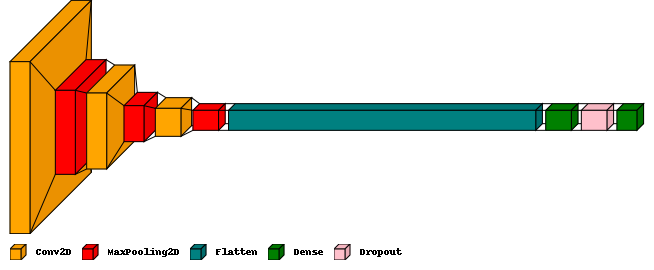

Bail out! EOG:ERROR:../src/eog-jobs.c:1162:eog_job_save_as_run: assertion failed: (job->error == NULL)



(eog:11056): GLib-WARNING **: 16:50:21.137: GError set over the top of a previous GError or uninitialized memory.
This indicates a bug in someone's code. You must ensure an error is NULL before it's set.
The overwriting error message was: Error in getting image file info
**
EOG:ERROR:../src/eog-jobs.c:1162:eog_job_save_as_run: assertion failed: (job->error == NULL)


In [12]:
import visualkeras
from collections import defaultdict


color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
# color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

# model = new_model
visualkeras.layered_view(model, color_map=color_map, legend=True).show()  # font is optional!
visualkeras.layered_view(model, color_map=color_map, legend=True, to_file='output.png') # write to disk

In [145]:
batch_size = 512
EPOCHS = 50
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=EPOCHS,
    validation_data=(X_eval, y_eval),
    callbacks=[model_checkpoint_callback],
    verbose=1
)

Epoch 1/50
8/8 [==============================] - 2s 44ms/step - loss: 1.2988 - accuracy: 0.5019 - val_loss: 0.6943 - val_accuracy: 0.4936
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 0.6985 - accuracy: 0.5031 - val_loss: 0.6931 - val_accuracy: 0.5176
Epoch 3/50
8/8 [==============================] - 0s 25ms/step - loss: 0.6948 - accuracy: 0.4964 - val_loss: 0.6932 - val_accuracy: 0.5016
Epoch 4/50
8/8 [==============================] - 0s 24ms/step - loss: 0.6939 - accuracy: 0.4924 - val_loss: 0.6929 - val_accuracy: 0.5080
Epoch 5/50
8/8 [==============================] - 0s 24ms/step - loss: 0.6926 - accuracy: 0.5194 - val_loss: 0.6930 - val_accuracy: 0.4928
Epoch 6/50
8/8 [==============================] - 0s 24ms/step - loss: 0.6936 - accuracy: 0.5059 - val_loss: 0.6929 - val_accuracy: 0.4832
Epoch 7/50
8/8 [==============================] - 0s 24ms/step - loss: 0.6923 - accuracy: 0.5162 - val_loss: 0.6925 - val_accuracy: 0.5208
Epoch 8/50
8/8 [===========

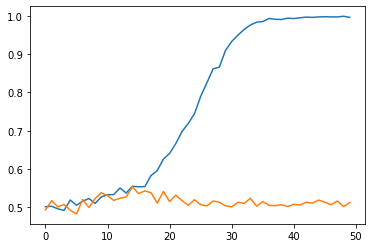

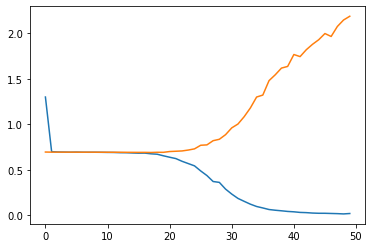

In [146]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [147]:
print("Max train acc: ", max(history.history["accuracy"]))
print("Max validation acc: ", max(history.history["val_accuracy"]))

Max train acc:  0.9984973669052124
Max validation acc:  0.5536859035491943


In [148]:
model.load_weights(checkpoint_filepath)
model.save('/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Models/Final/in-up-down')

16-Apr-23 14:50:46 | WARNING | Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


In [155]:
new_model = tf.keras.models.load_model('/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Models/Final/in-up-down')

y_pred = np.argmax(new_model.predict(X_test), axis=1)
# y_pred = [1 if x > 0.5 else 0 for x in model.predict(X_test)]  # Binary classification (sigmoid)
y_true = y_test
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy main: {test_acc:.0%}')

32/32 [==============================] - 0s 2ms/step
Test set accuracy main: 62%


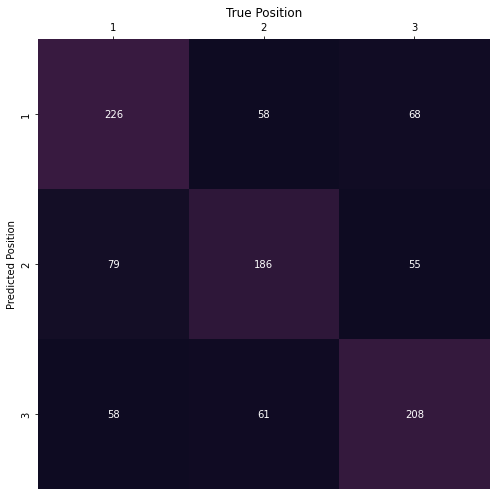

In [156]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize = (7,7))
hm1 = sns.heatmap(confusion_matrix, annot=True, cbar=False, vmin=0, vmax=1500,fmt='g')

hm1.set(title='True Position', ylabel='Predicted Position')
hm1.xaxis.tick_top()

hm1.set_xticklabels([int(i.get_text())+1 for i in hm1.get_xticklabels()])
hm1.set_yticklabels([int(i.get_text())+1 for i in hm1.get_yticklabels()])
plt.tight_layout()
# file_name = "beat_classification_confusion_matrix_reverse_sizes"
# os.chdir('/mnt/sda1/shivam/DrummingEEG/FullStudyData/images')
# hm1.get_figure().savefig(file_name + ".png")